# Benchmark and Visualization TCC Feadback Perturbation No Feedback

In [1]:
import os
import pathlib
import uuid
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm

import LZH_Utilities as utl

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [2]:
DATA_FOLDER_PATH = "Output/new_perturbation_softclamp_no_feedback_no_softclamp/"
os.makedirs(DATA_FOLDER_PATH, exist_ok=True)
# DATA_FOLDER_PATH = "Output/new_perturbation_NO_softclamp/"

MAX_SAMPLE_COUNT = 200
NUM_CPU_THREADS = 32
TOTAL_SAMPLE_GENERATED = MAX_SAMPLE_COUNT - len(os.listdir(DATA_FOLDER_PATH))
PARAMETER_NAMES = ["LTS", "SST", "Subsidence", "Night_Day", "RH", "q", "wsp", "TCC"]

In [3]:
torch.set_num_threads(NUM_CPU_THREADS)
directory = utl.Archive(DATA_FOLDER_PATH)

In [4]:
def get_datasets():
    df = utl.read_time_series_data("full_rank_dataset")

    df[0]["TCC_FB"] = 0
    for idx in np.arange(8):
        df[idx+1]["TCC_FB"] = df[idx]["TCC"]

    # assigning new order
    col = list(df[0].columns)
    new_col = col[:8]
    new_col.append(col[-1])
    new_col.append(col[-3])
    new_col.append(col[-2])

    for idx in np.arange(len(df)):
        df[idx] = df[idx][new_col]
    idx_test_set = np.random.choice(np.arange(df[0].shape[0]), [int(0.1 * df[0].shape[0])], False)
    idx_training_set = np.delete(np.arange(df[0].shape[0]), idx_test_set)
    time_arr = np.arange(9)

    X_full = [df[time].iloc[:, np.arange(7) + 1].to_numpy() for time in time_arr]
    y_hat_full = [np.c_[df[time].iloc[:, -2].to_numpy()] for time in time_arr]

    X_train = np.array([X_full[time][idx_training_set] for time in time_arr])
    y_hat_train = np.array([y_hat_full[time][idx_training_set] for time in time_arr])

    X_test = np.array([X_full[time][idx_test_set] for time in time_arr])
    y_hat_test = np.array([y_hat_full[time][idx_test_set] for time in time_arr])

    return ((X_train, y_hat_train), (X_test, y_hat_test))

In [5]:
class MLTCC_Model_GRU_Normalized:
    def __init__(self):
        self.NMR = utl.Normalizer()
        
        self.input_size = 7
        self.output_size = 1
        self.batch_size = 10000
        self.step_size = 1e-3
        
        h_gru = 50
        h1 = 20
        h2 = 40
        h3 = 20
        
        self.gru = nn.GRU(self.input_size, h_gru, 2, batch_first=False)   # (seq, batch, feature)
        self.fc1 = nn.Linear(h_gru, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, self.output_size)
        
        variable_list = [
                self.fc1.weight, self.fc1.bias,
                self.fc2.weight, self.fc2.bias,
                self.fc3.weight, self.fc3.bias,
                self.fc4.weight, self.fc4.bias
            ]
        for all_weights in self.gru.all_weights:
            for weights in all_weights:
                variable_list.append(weights)
        
        
        self.optim = torch.optim.Adam(
            variable_list,
            lr=self.step_size
        )
        
    def foward(self, X):
        """
        X := [LTS, SST, Subsidence], (sample_size, 4) like tensor
        y := [TCC],                  (sample_size, 1) like tensor
        """
#         seq_X_result = []
#         for seq_X in X:
#             seq_X_result.append(torch.relu(self.fc1(seq_X.float())))
#         seq_X_result = tsr(seq_X_result)
        # normalize
        newX = []
        for idx in np.arange(X.shape[0]):
            newX.append(self.NMR.normalize_input(X[idx]).detach().numpy())
        X = torch.tensor(np.array(newX))

        X = X.float()
    
        X_gru_outputs, hn = self.gru(X)
        X = torch.relu(X_gru_outputs[-1]) # use last output
        
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        X = torch.relu(self.fc3(X))
        X = self.fc4(X)
        
        return self.NMR.denormalize_output(X)

    def forward_numpy(self, X):
        """This is only for making preditions"""
        return self.foward(torch.tensor(X)).detach().numpy()
    
    def loss(self, y, y_hat):
        """
        y := [TCC],                  (sample_size, 1) like tensor
        y_hat := [TCC],              (sample_size, 1) like tensor
        """
        return F.mse_loss(y.float(), y_hat.float())
    
    def train(self, X, y_hat, max_epoch):
        """
        X := [LTS, SST, Subsidence], (sample_size, 4) like matrix
        y_hat := [TCC],              (sample_size, 1) like matrix
        """
        sample_count = X.shape[1]
        
        epoch_num = []
        losses = []
        
        for i in np.arange(max_epoch):
            for idx_batch in np.arange(int(sample_count / self.batch_size)) * self.batch_size:
                X_batch = torch.tensor(X[:, idx_batch:idx_batch + self.batch_size, :])
                y_hat_batch = torch.tensor(y_hat[idx_batch:idx_batch + self.batch_size, :])
                y_batch = self.foward(X_batch)
                # y_batch = utl.softclamp(y_batch, 0, 100, 1000, 1000)
                loss = self.loss(y_batch.t(), y_hat_batch.t())
                
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
                
            idx_rand = np.random.randint(0, sample_count, [self.batch_size])
            X_batch = torch.tensor(X[:, idx_rand, :]).float()
            y_hat_batch = torch.tensor(y_hat[idx_rand, :]).float()
            y_batch = self.foward(X_batch)
            
            loss = self.loss(y_batch, y_hat_batch)
            
            epoch_num.append(i)
            losses.append(loss.item())
            
        return (epoch_num, losses)
    
    
    def train_time_series(self, X, y_hat, max_epoch, max_epoch_per_time):
        """
        X := [LTS, SST, Subsidence], (sample_size, 4) like matrix
        y_hat := [TCC],              (sample_size, 1) like matrix
        """
        
        # setting normalizer
        # flatten X and y_hat
        X_flat = np.concatenate(X, axis=0)
        y_hat_flat = np.concatenate(y_hat, axis=0)
        
        self.NMR.set_mean_and_sd(torch.tensor(X_flat), torch.tensor(y_hat_flat))
        
        full_losses = np.array([])

        for i, time in (pbar := tqdm([(i, time) for i in np.arange(max_epoch) for time in np.arange(9)])):
            pbar.set_description(f"Training, Epoch {i+1} / {max_epoch}")
            
            (x_axis, losses) = self.train(X[:time+1, :, :], y_hat[time, :, :], max_epoch_per_time)
            full_losses = np.concatenate((full_losses, losses))
            
        return (np.arange(len(full_losses)) + 1, full_losses)

In [6]:
def perturb_parameter(X, param_idx, delta): 
    """Adding delta to param_idx for all time and sample"""
    X_copy = np.copy(X)
    X_copy[:, :, param_idx] = X_copy[:, :, param_idx] + delta
    return X_copy

In [7]:
def WORK():
    ((X_train, y_hat_train), (X_test, y_hat_test)) = get_datasets()

    tcc_model_gru = MLTCC_Model_GRU_Normalized()
    tcc_model_gru.train_time_series(X_train, y_hat_train, 40, 5)

    parameters_std = np.array([
        np.std(X_test[:, :, parameter_idx])
        for parameter_idx in np.arange(X_test.shape[2])
    ])
    all_parameter_idx = np.arange(7)
    all_perturbation = np.linspace(-2, 2, 201)

    res_perturbation = []
    with tqdm(total=len(all_parameter_idx)*len(all_perturbation)) as pbar:
        for parameter_idx in all_parameter_idx:
            pbar.set_description(f"Calc Param Perturbation at idx={parameter_idx}")

            res_parameter_perturbation = []
            for perturbation in all_perturbation:

                std = parameters_std[parameter_idx]

                new_X = perturb_parameter(X_test, parameter_idx, std * perturbation)
                new_y_fit = tcc_model_gru.forward_numpy(new_X)[:, 0]

                res_parameter_perturbation.append(dict(
                    parameter_idx=parameter_idx,
                    parameter_std = std,
                    perturbation=perturbation,
                    
                    min=np.min(new_y_fit),
                    percentile25=np.percentile(new_y_fit, 25),
                    mean = np.mean(new_y_fit),
                    percentile75=np.percentile(new_y_fit, 75),
                    max=np.max(new_y_fit),
                    std=np.std(new_y_fit),
                ))

                pbar.update(1)

            res_perturbation.append(res_parameter_perturbation)

    directory.save_data(res_perturbation, f"Perturbation_Stats_{uuid.uuid1()}.pkl")

In [8]:
def main_data_generation():
    for i in np.arange(TOTAL_SAMPLE_GENERATED): 
        print(f"Processing Job {i+1} / {TOTAL_SAMPLE_GENERATED}")
        WORK()

In [9]:
if __name__ == "__main__":
    main_data_generation()

## Visualization

In [10]:
def get_all_data_file_names():
    file_name_pattern = re.compile("Perturbation_Stats")
    file_names = [file_name for file_name in os.listdir(DATA_FOLDER_PATH) if file_name_pattern.match(file_name) is not None]
    print(f"File Count: {len(file_names)}")
    return file_names

In [11]:
def load_stats(directory: utl.Archive, file_names):
    """Load all dataset in stats
    
    Returns
    -------
    raw_stats Dimensions: (8, 201, number of samples, dict())
        - parameters: 8
        - perturbation: 201
        - samples: number of sample
        - contents: as dict
            - paramter_idx
            - parameter_std
            - perturbation
            - min
            - percentile25
            - mean
            - percentile75
            - max
            - std
    """
    raw_stats = []
    for file_name in file_names:
        raw_stats.append(directory.load_data(file_name))

    swap = [
        [
            [
                raw_stats[sample_idx][parameter_idx][perturbation_idx]
                for sample_idx in np.arange(len(raw_stats))
            ]
            for perturbation_idx in np.arange(len(raw_stats[0][0]))
        ]
        for parameter_idx in np.arange(len(raw_stats[0]))
    ]
    return swap

In [12]:
def format_stats(raw_stats):
    """format stats from `load_stats()` method
    
    Returns
    -------
    dictionary of pd.DataFrame that contains the stats
    """
    
    df_stats = {
        PARAMETER_NAMES[parameter_idx]: pd.DataFrame(
            data=[
                {
                    "perturbation"  : raw_stats[parameter_idx][perturbation_idx][sample_idx]["perturbation"  ] ,
                    "parameter_std" : raw_stats[parameter_idx][perturbation_idx][sample_idx]["parameter_std" ] ,
                    'min'           : raw_stats[parameter_idx][perturbation_idx][sample_idx]["min"           ] ,
                    'percentile25'  : raw_stats[parameter_idx][perturbation_idx][sample_idx]["percentile25"  ] ,
                    'mean'          : raw_stats[parameter_idx][perturbation_idx][sample_idx]["mean"          ] ,
                    'percentile75'  : raw_stats[parameter_idx][perturbation_idx][sample_idx]["percentile75"  ] ,
                    'max'           : raw_stats[parameter_idx][perturbation_idx][sample_idx]["max"           ] ,
                    'std'           : raw_stats[parameter_idx][perturbation_idx][sample_idx]["std"           ] ,
                }
                for perturbation_idx in np.arange(len(raw_stats[parameter_idx]))
                for sample_idx in np.arange(len(raw_stats[parameter_idx][perturbation_idx]))
            ]
        )
        for parameter_idx in np.arange(len(raw_stats))
    }

    return df_stats


In [13]:
raw_stats = load_stats(directory, get_all_data_file_names()) 
df_stats = format_stats(raw_stats)

File Count: 200


In [14]:
PARAMETER_NAMES

['LTS', 'SST', 'Subsidence', 'Night_Day', 'RH', 'q', 'wsp', 'TCC']

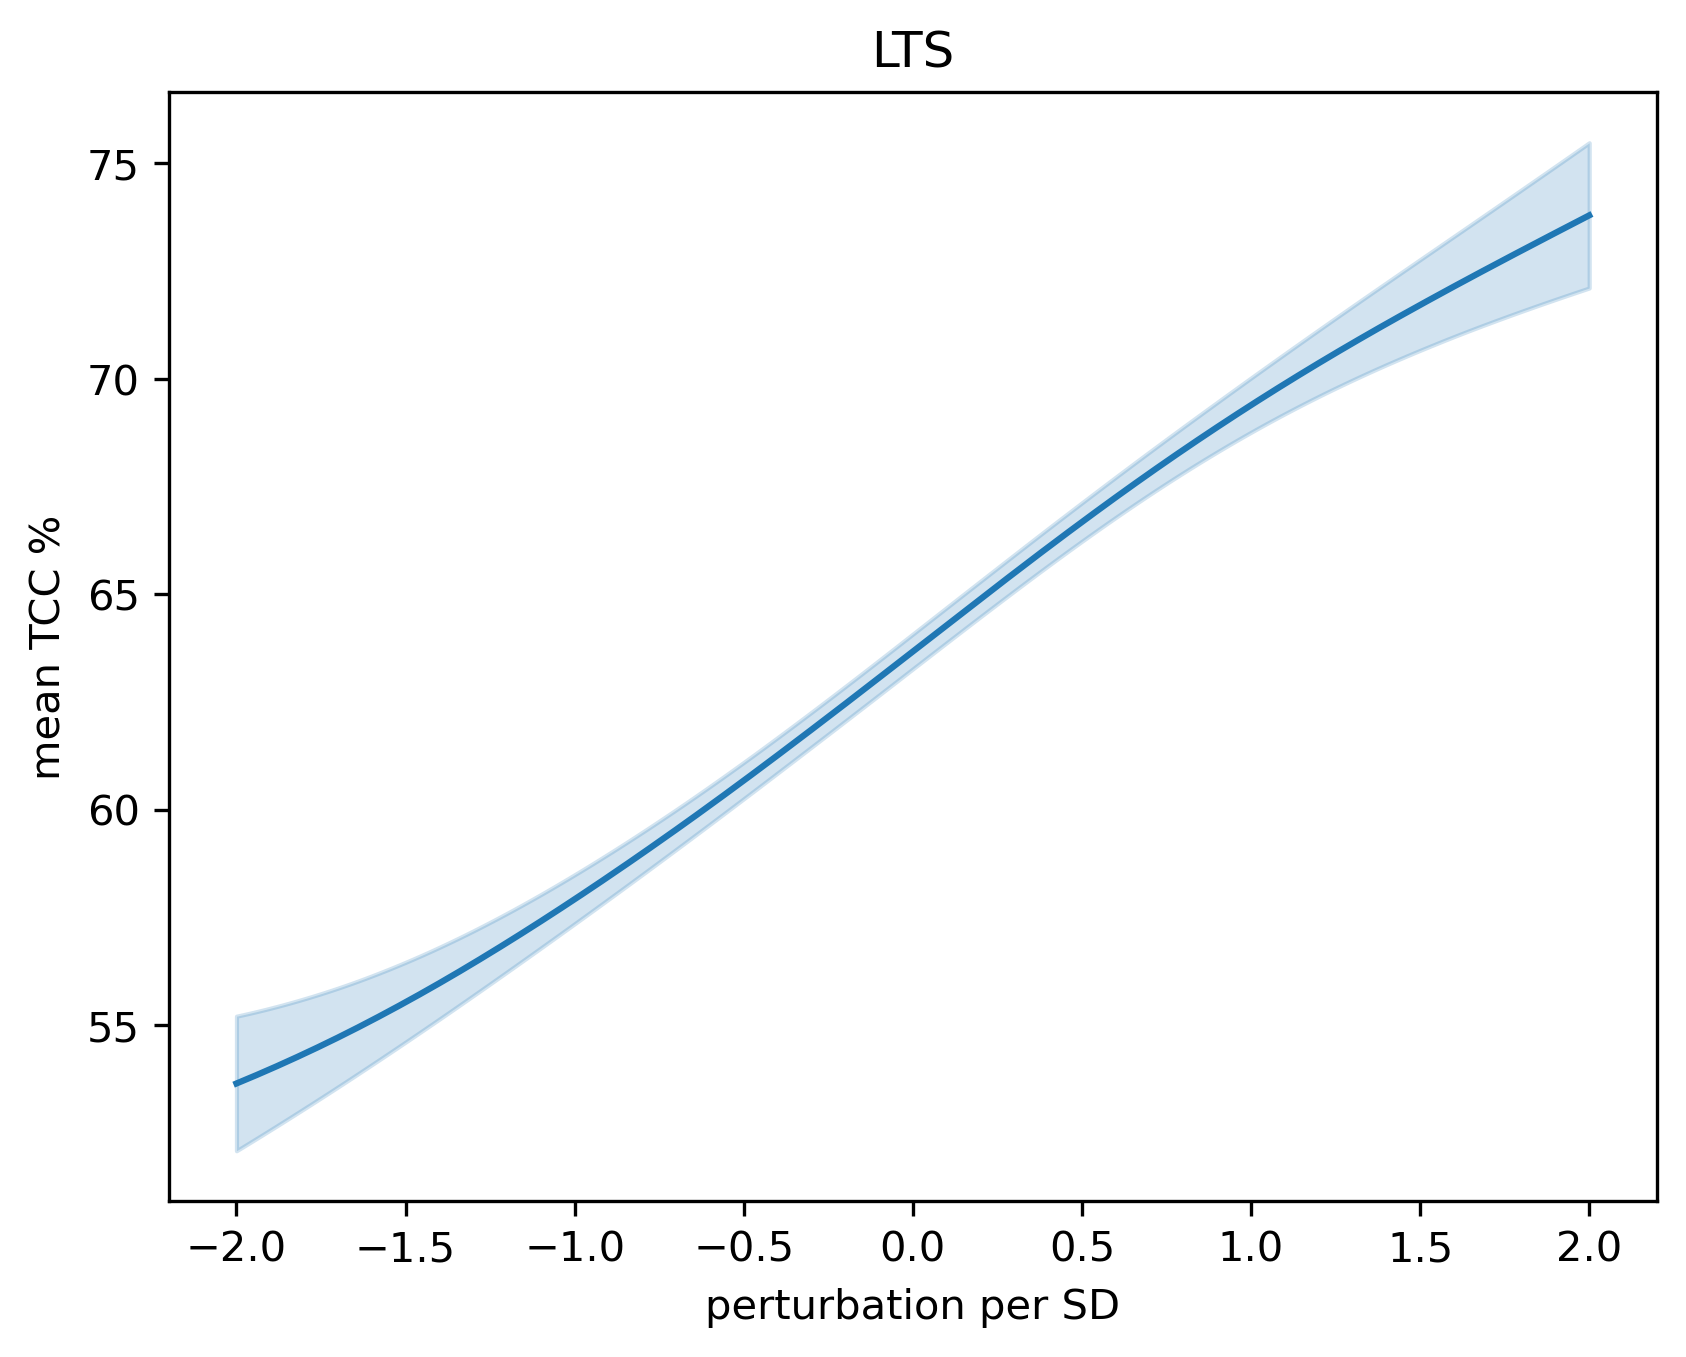

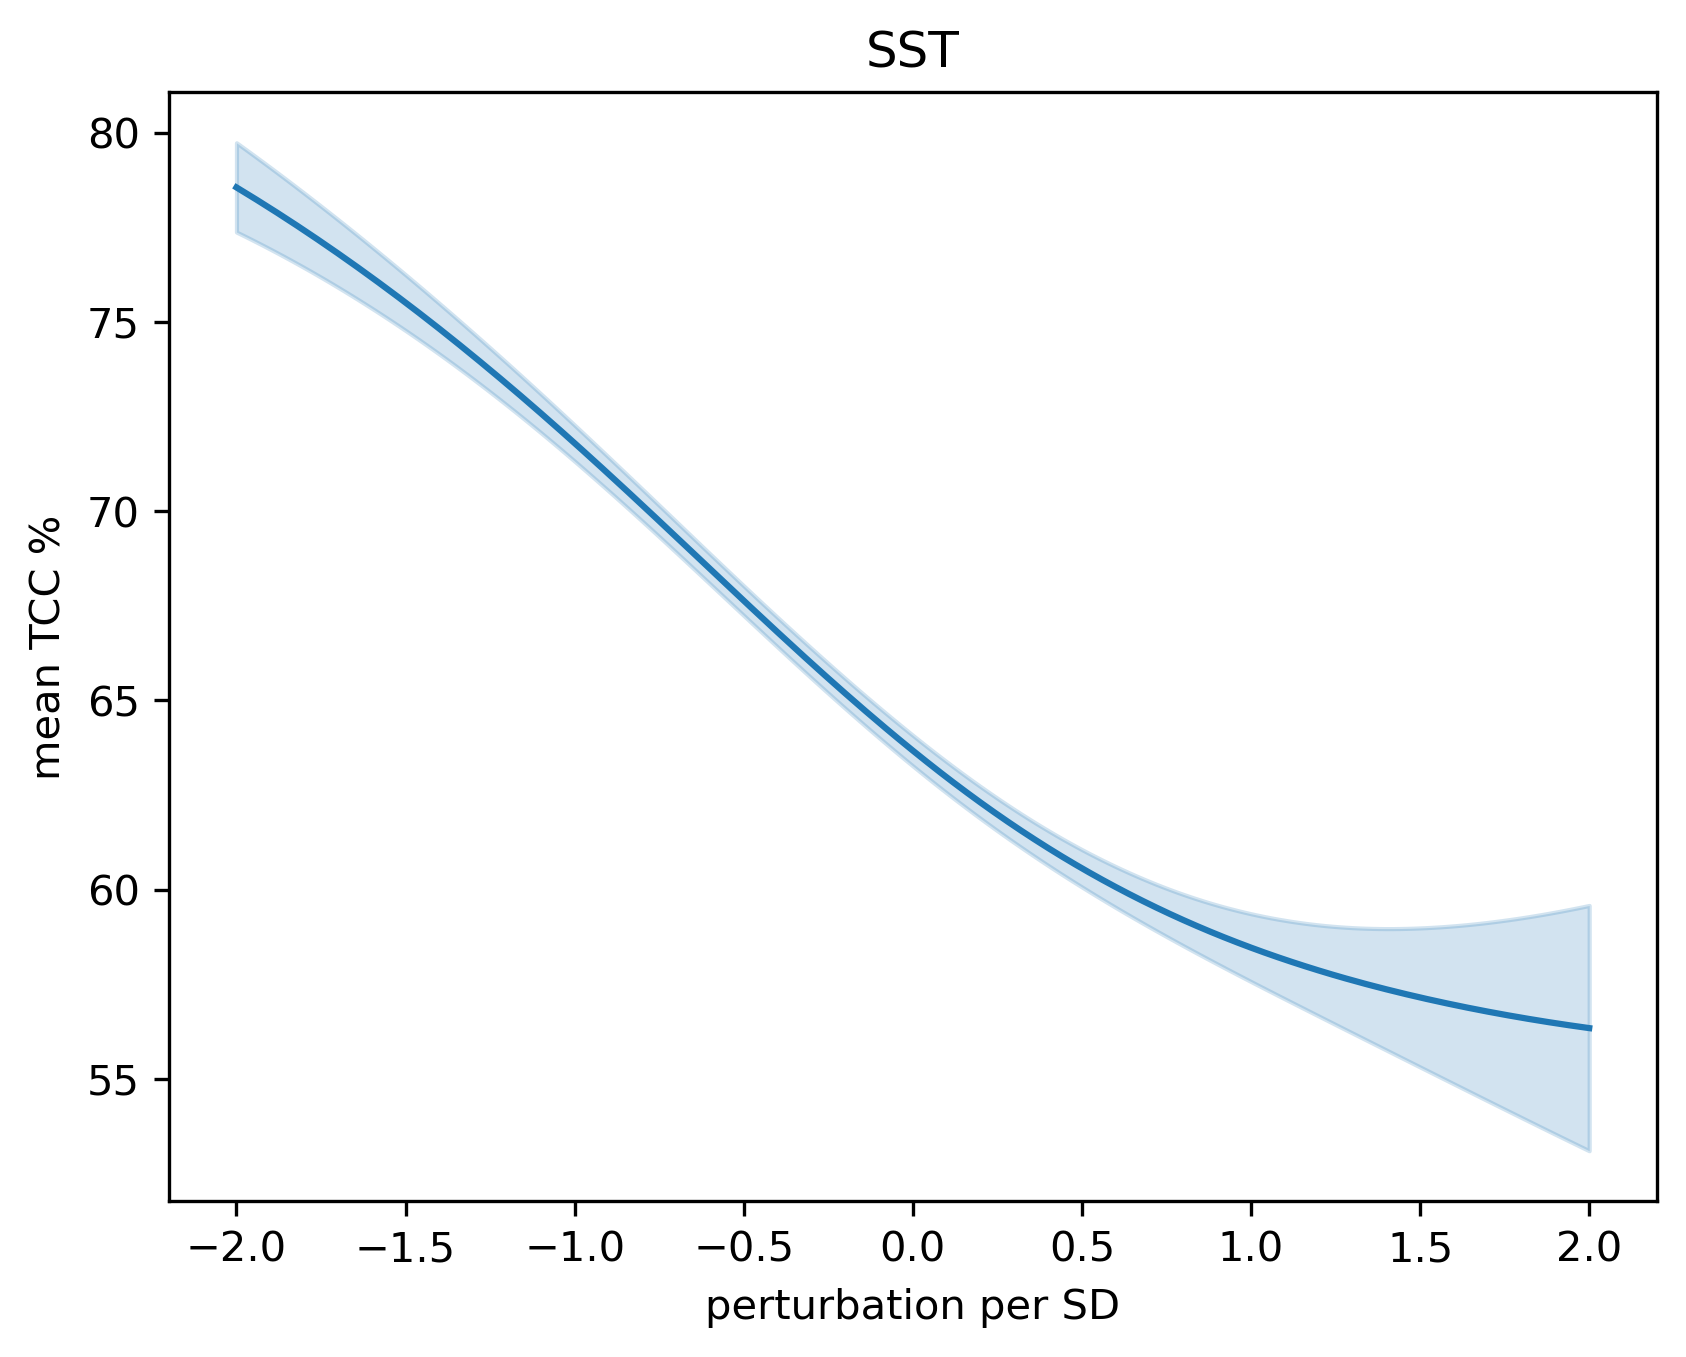

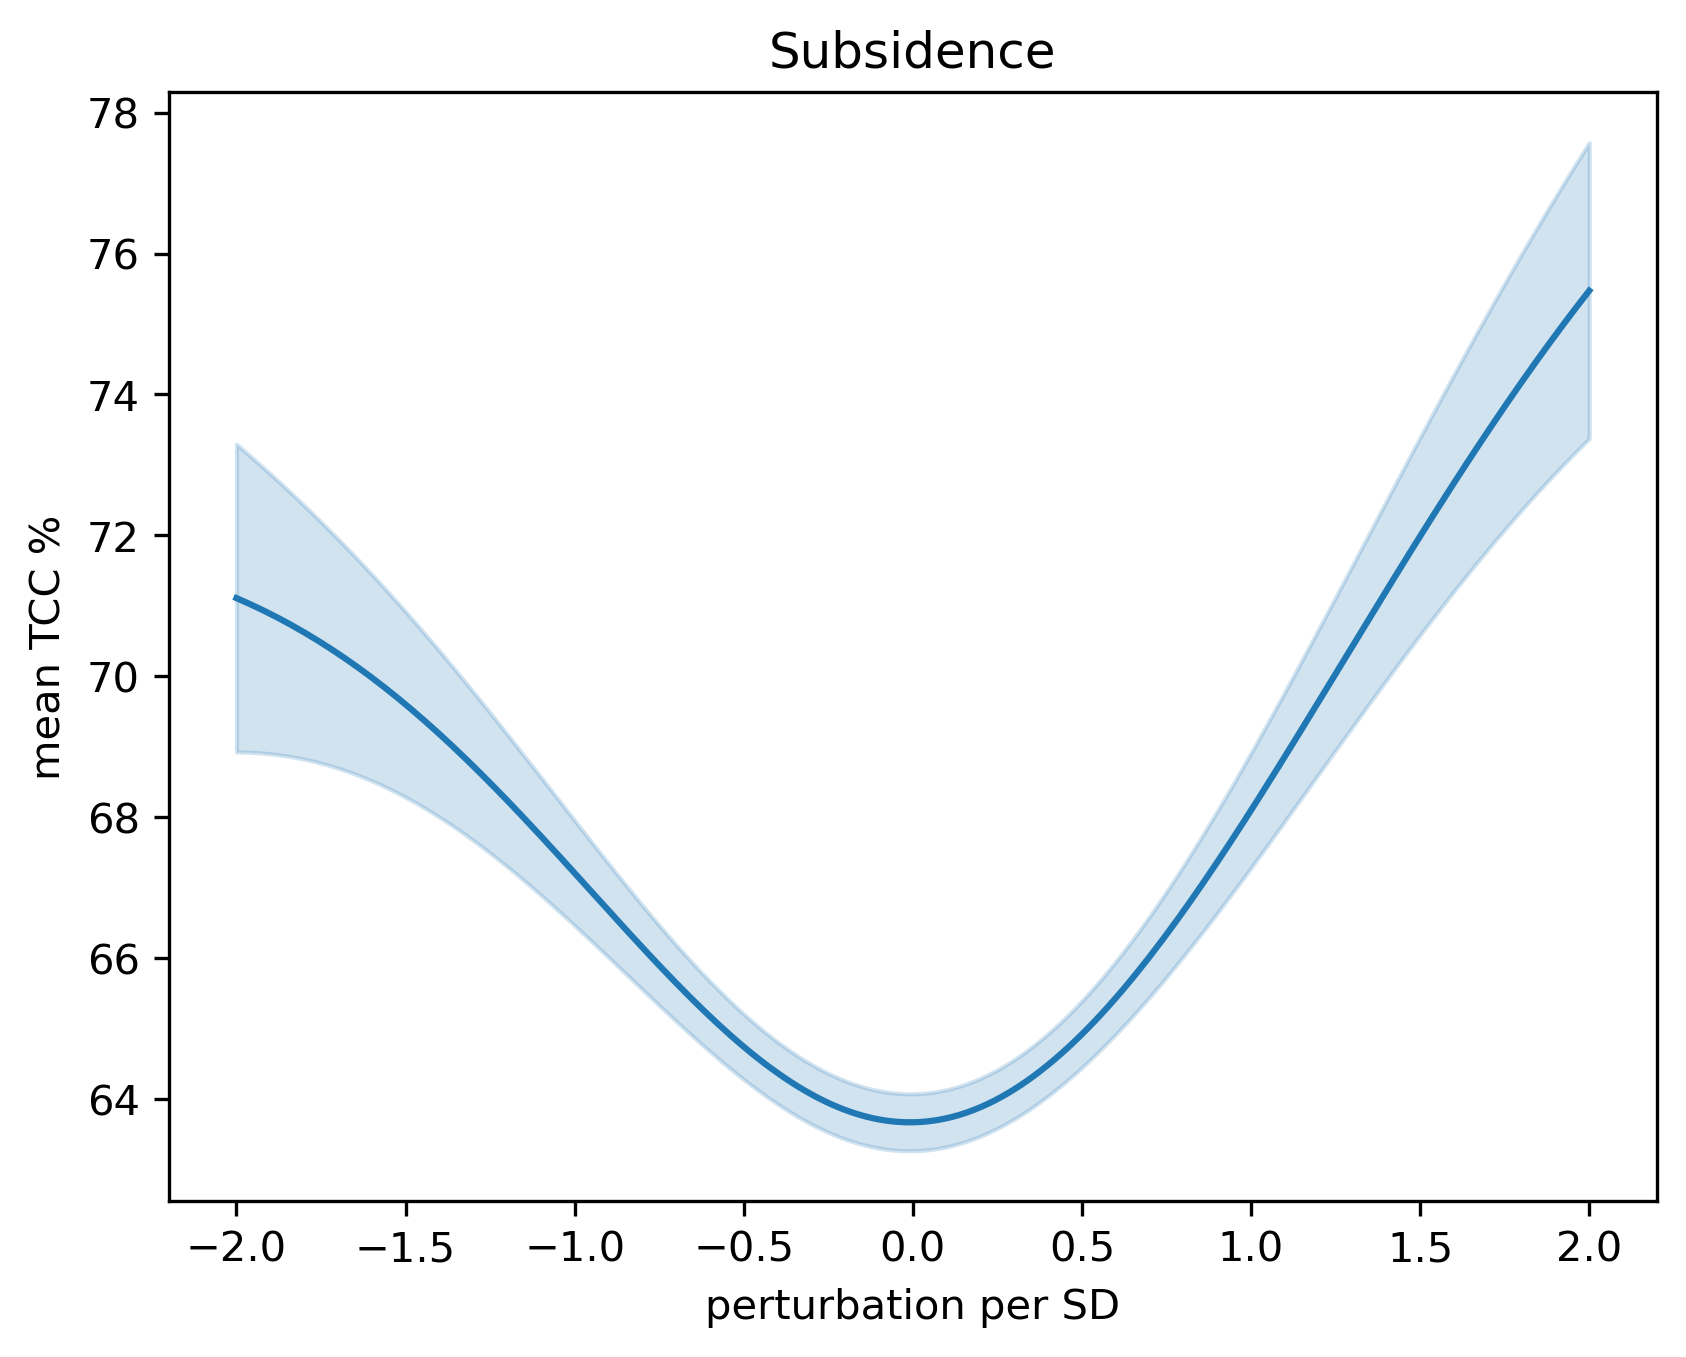

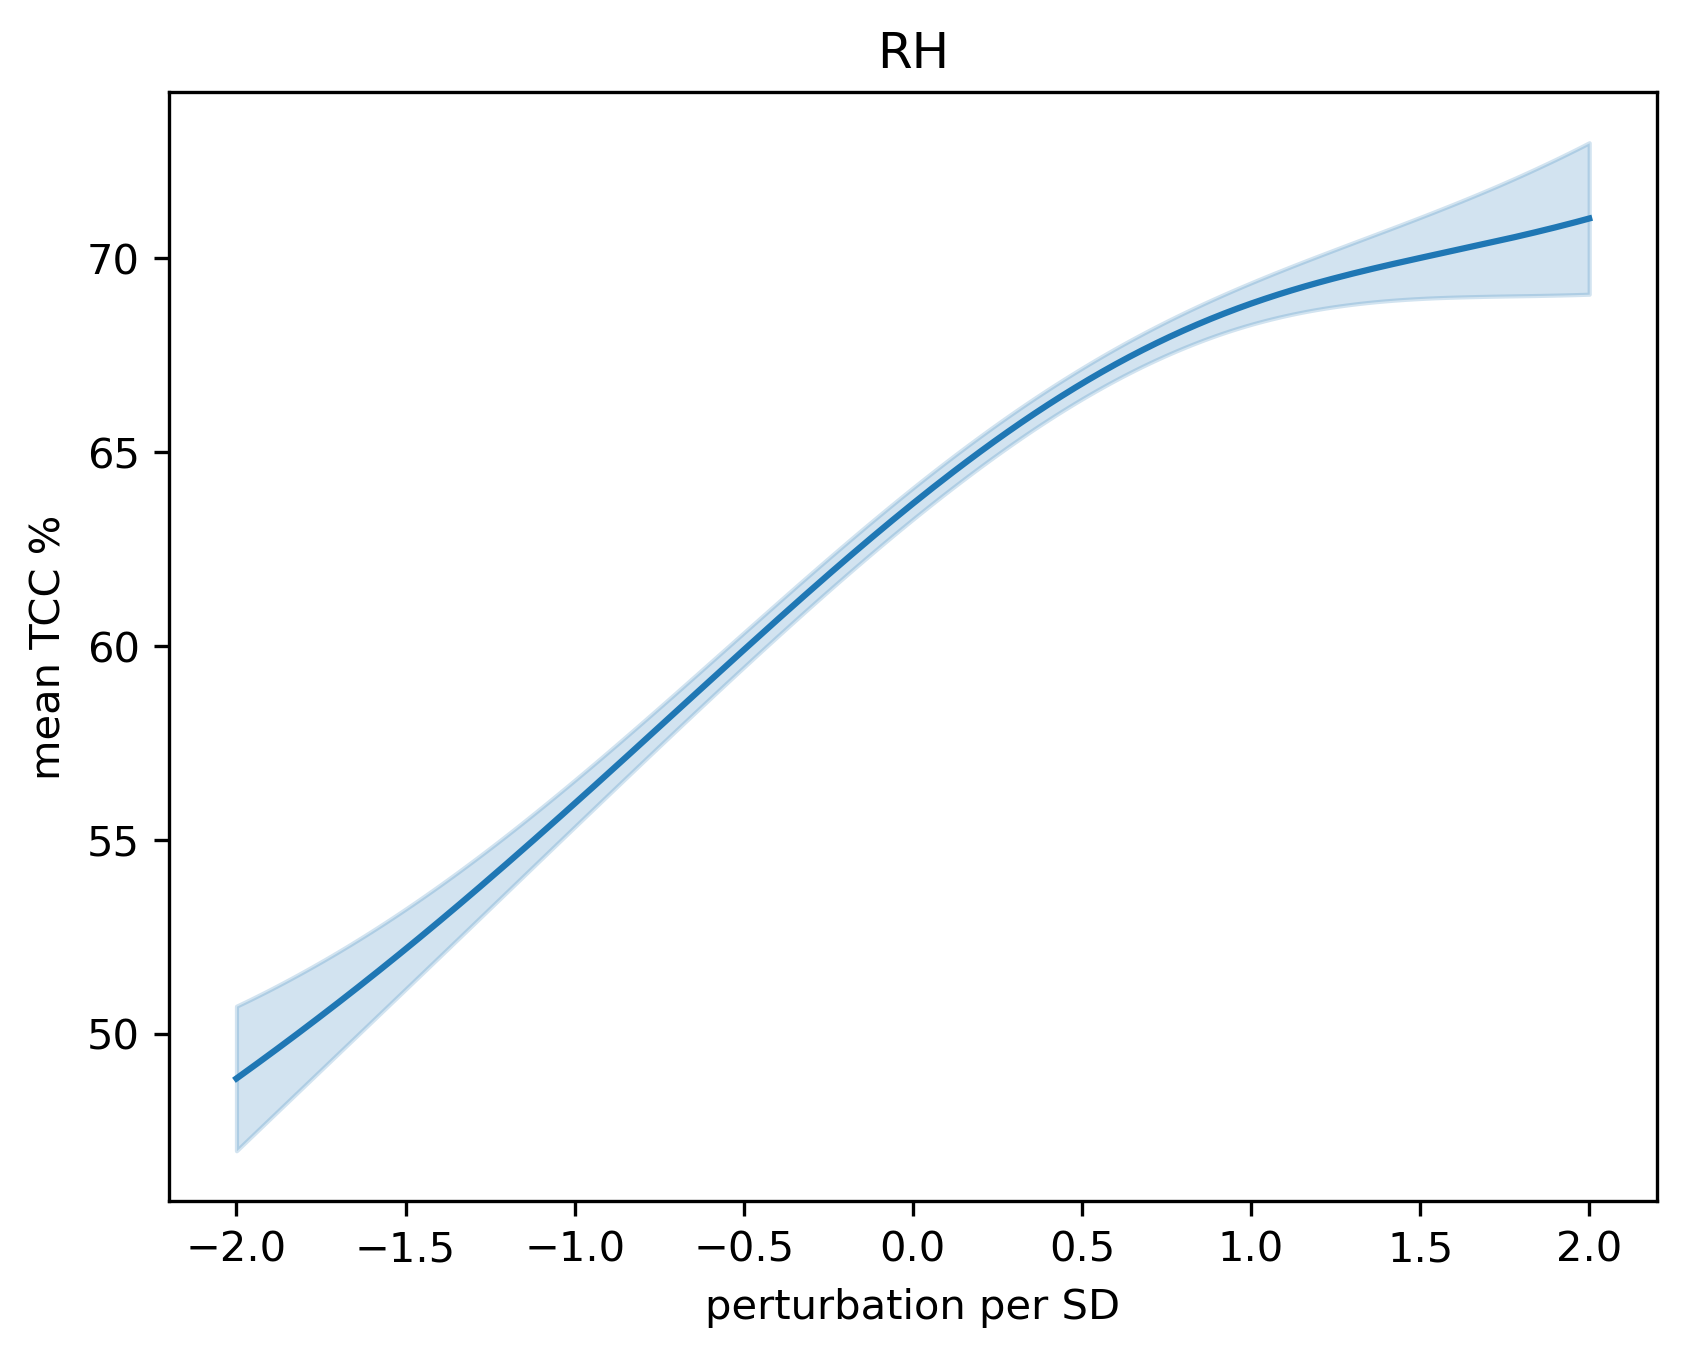

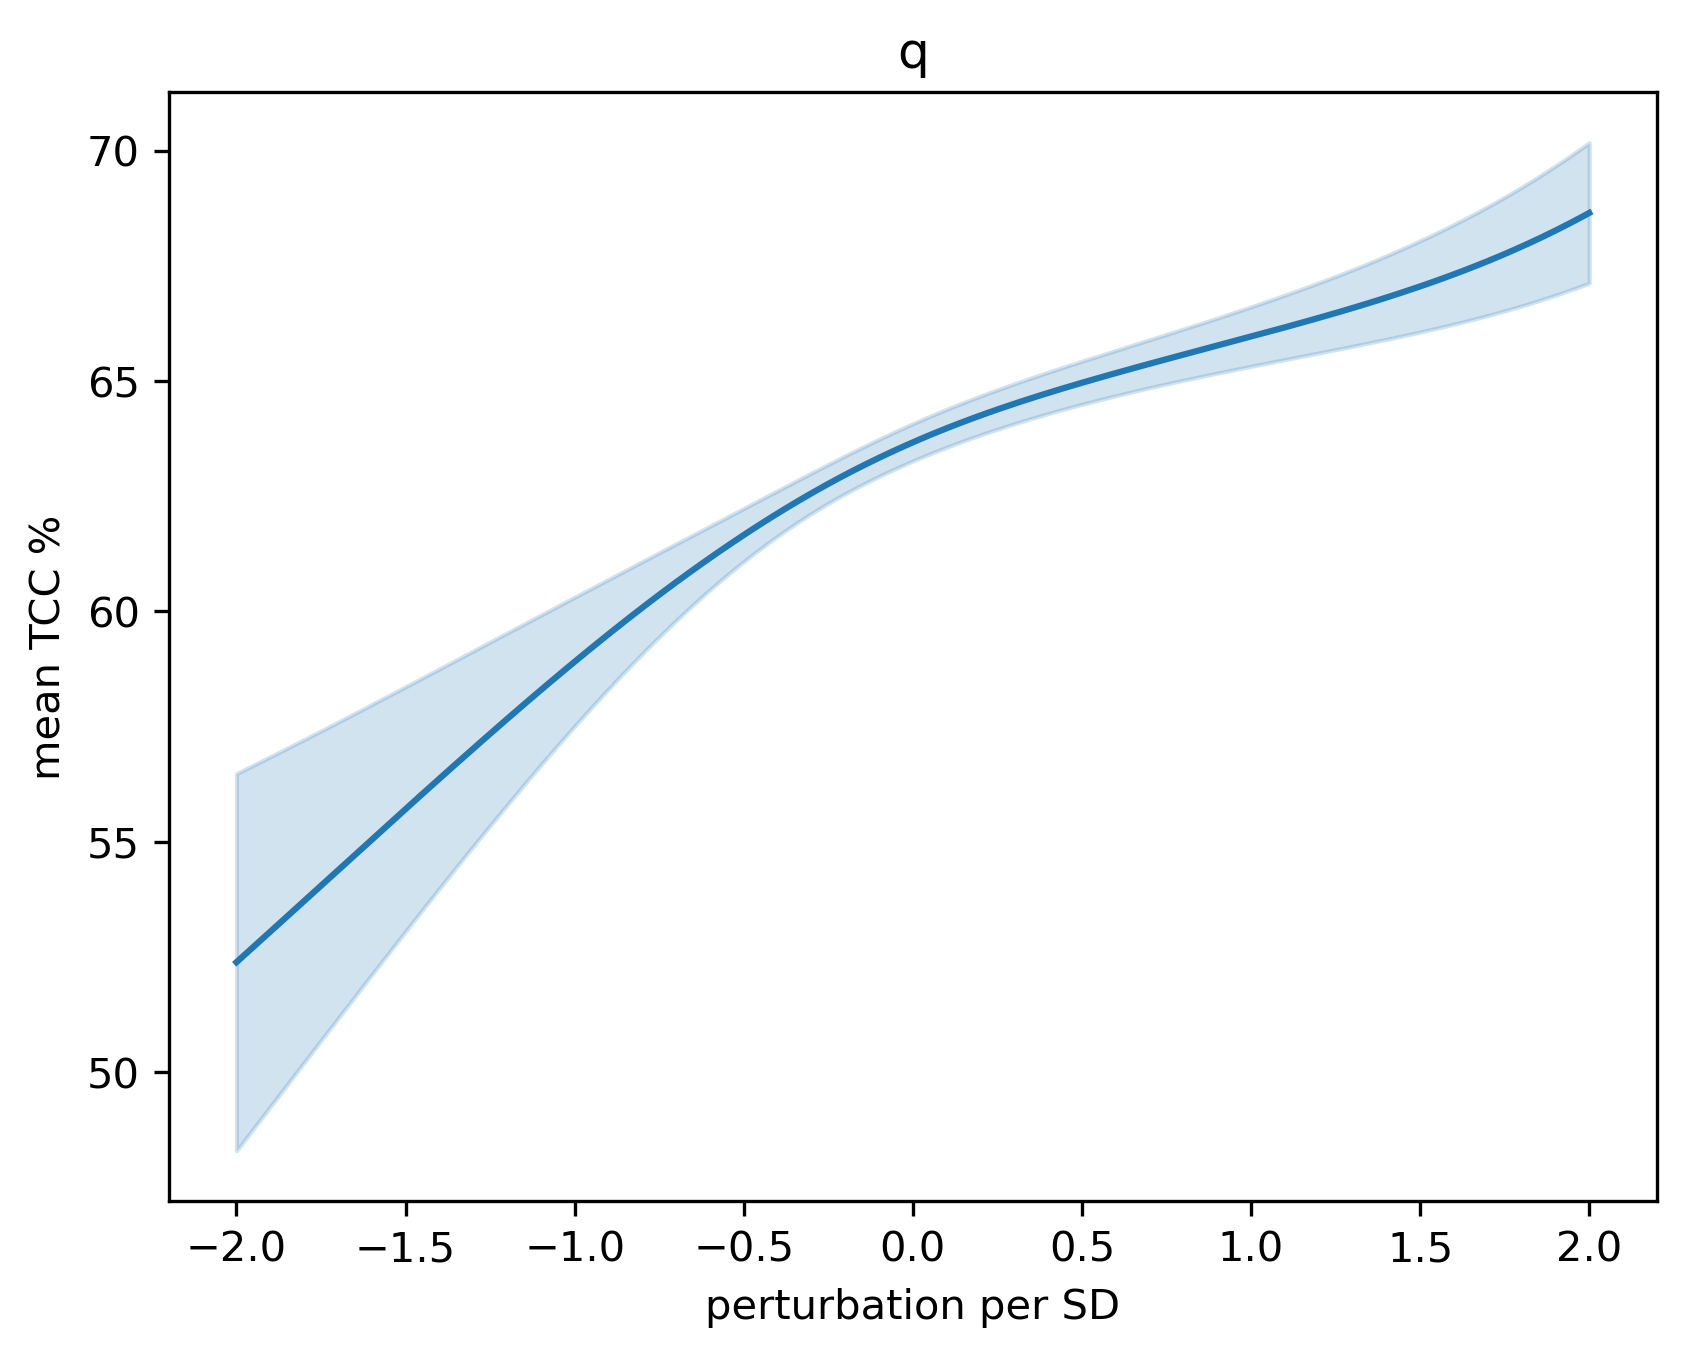

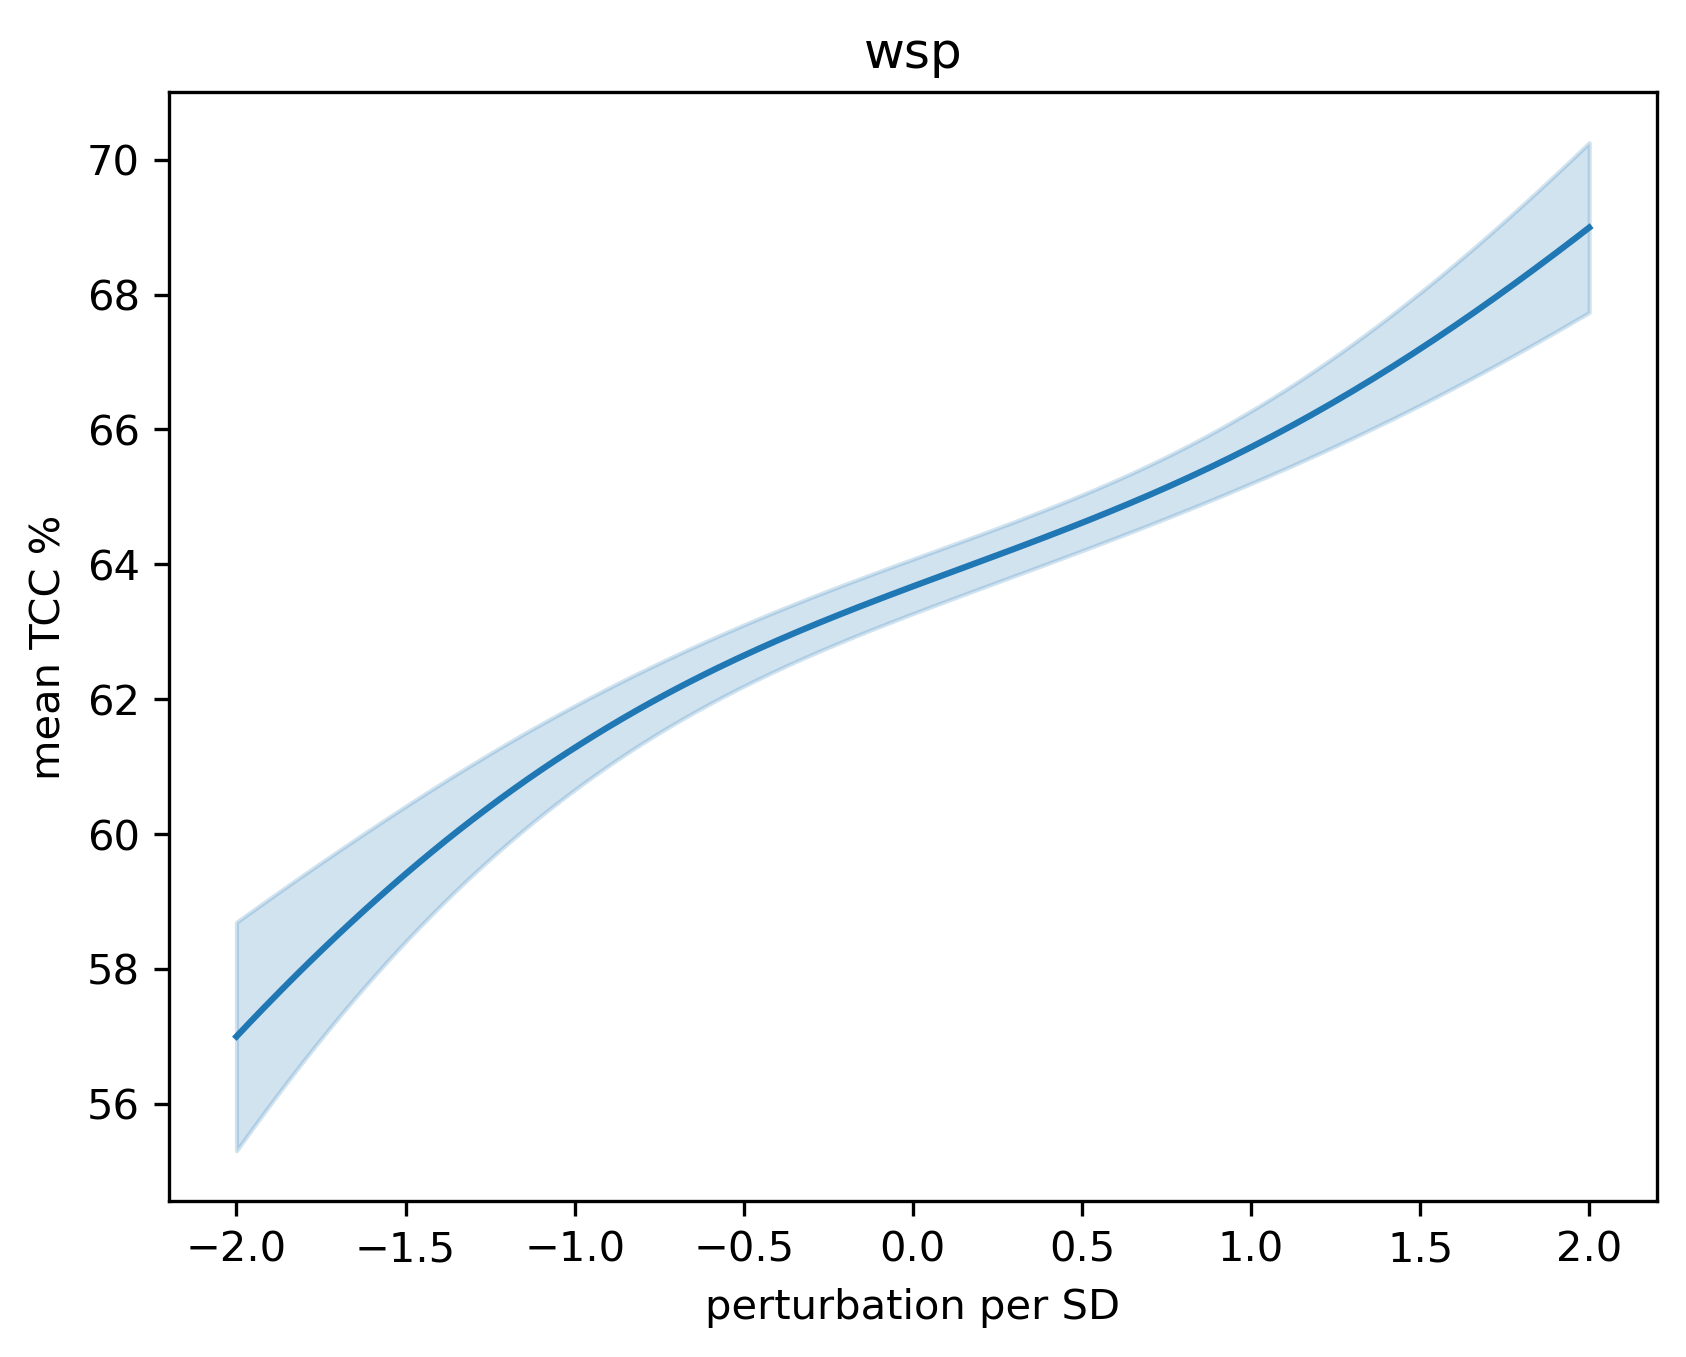

In [15]:
for parameter_name in ['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp']:
    sns.lineplot(
        data=df_stats[parameter_name],
        x="perturbation",
        y="mean",
        errorbar=("sd")
    ).set(
        title=parameter_name,
        ylabel="mean TCC %",
        xlabel="perturbation per SD",
    )
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  9.44it/s]


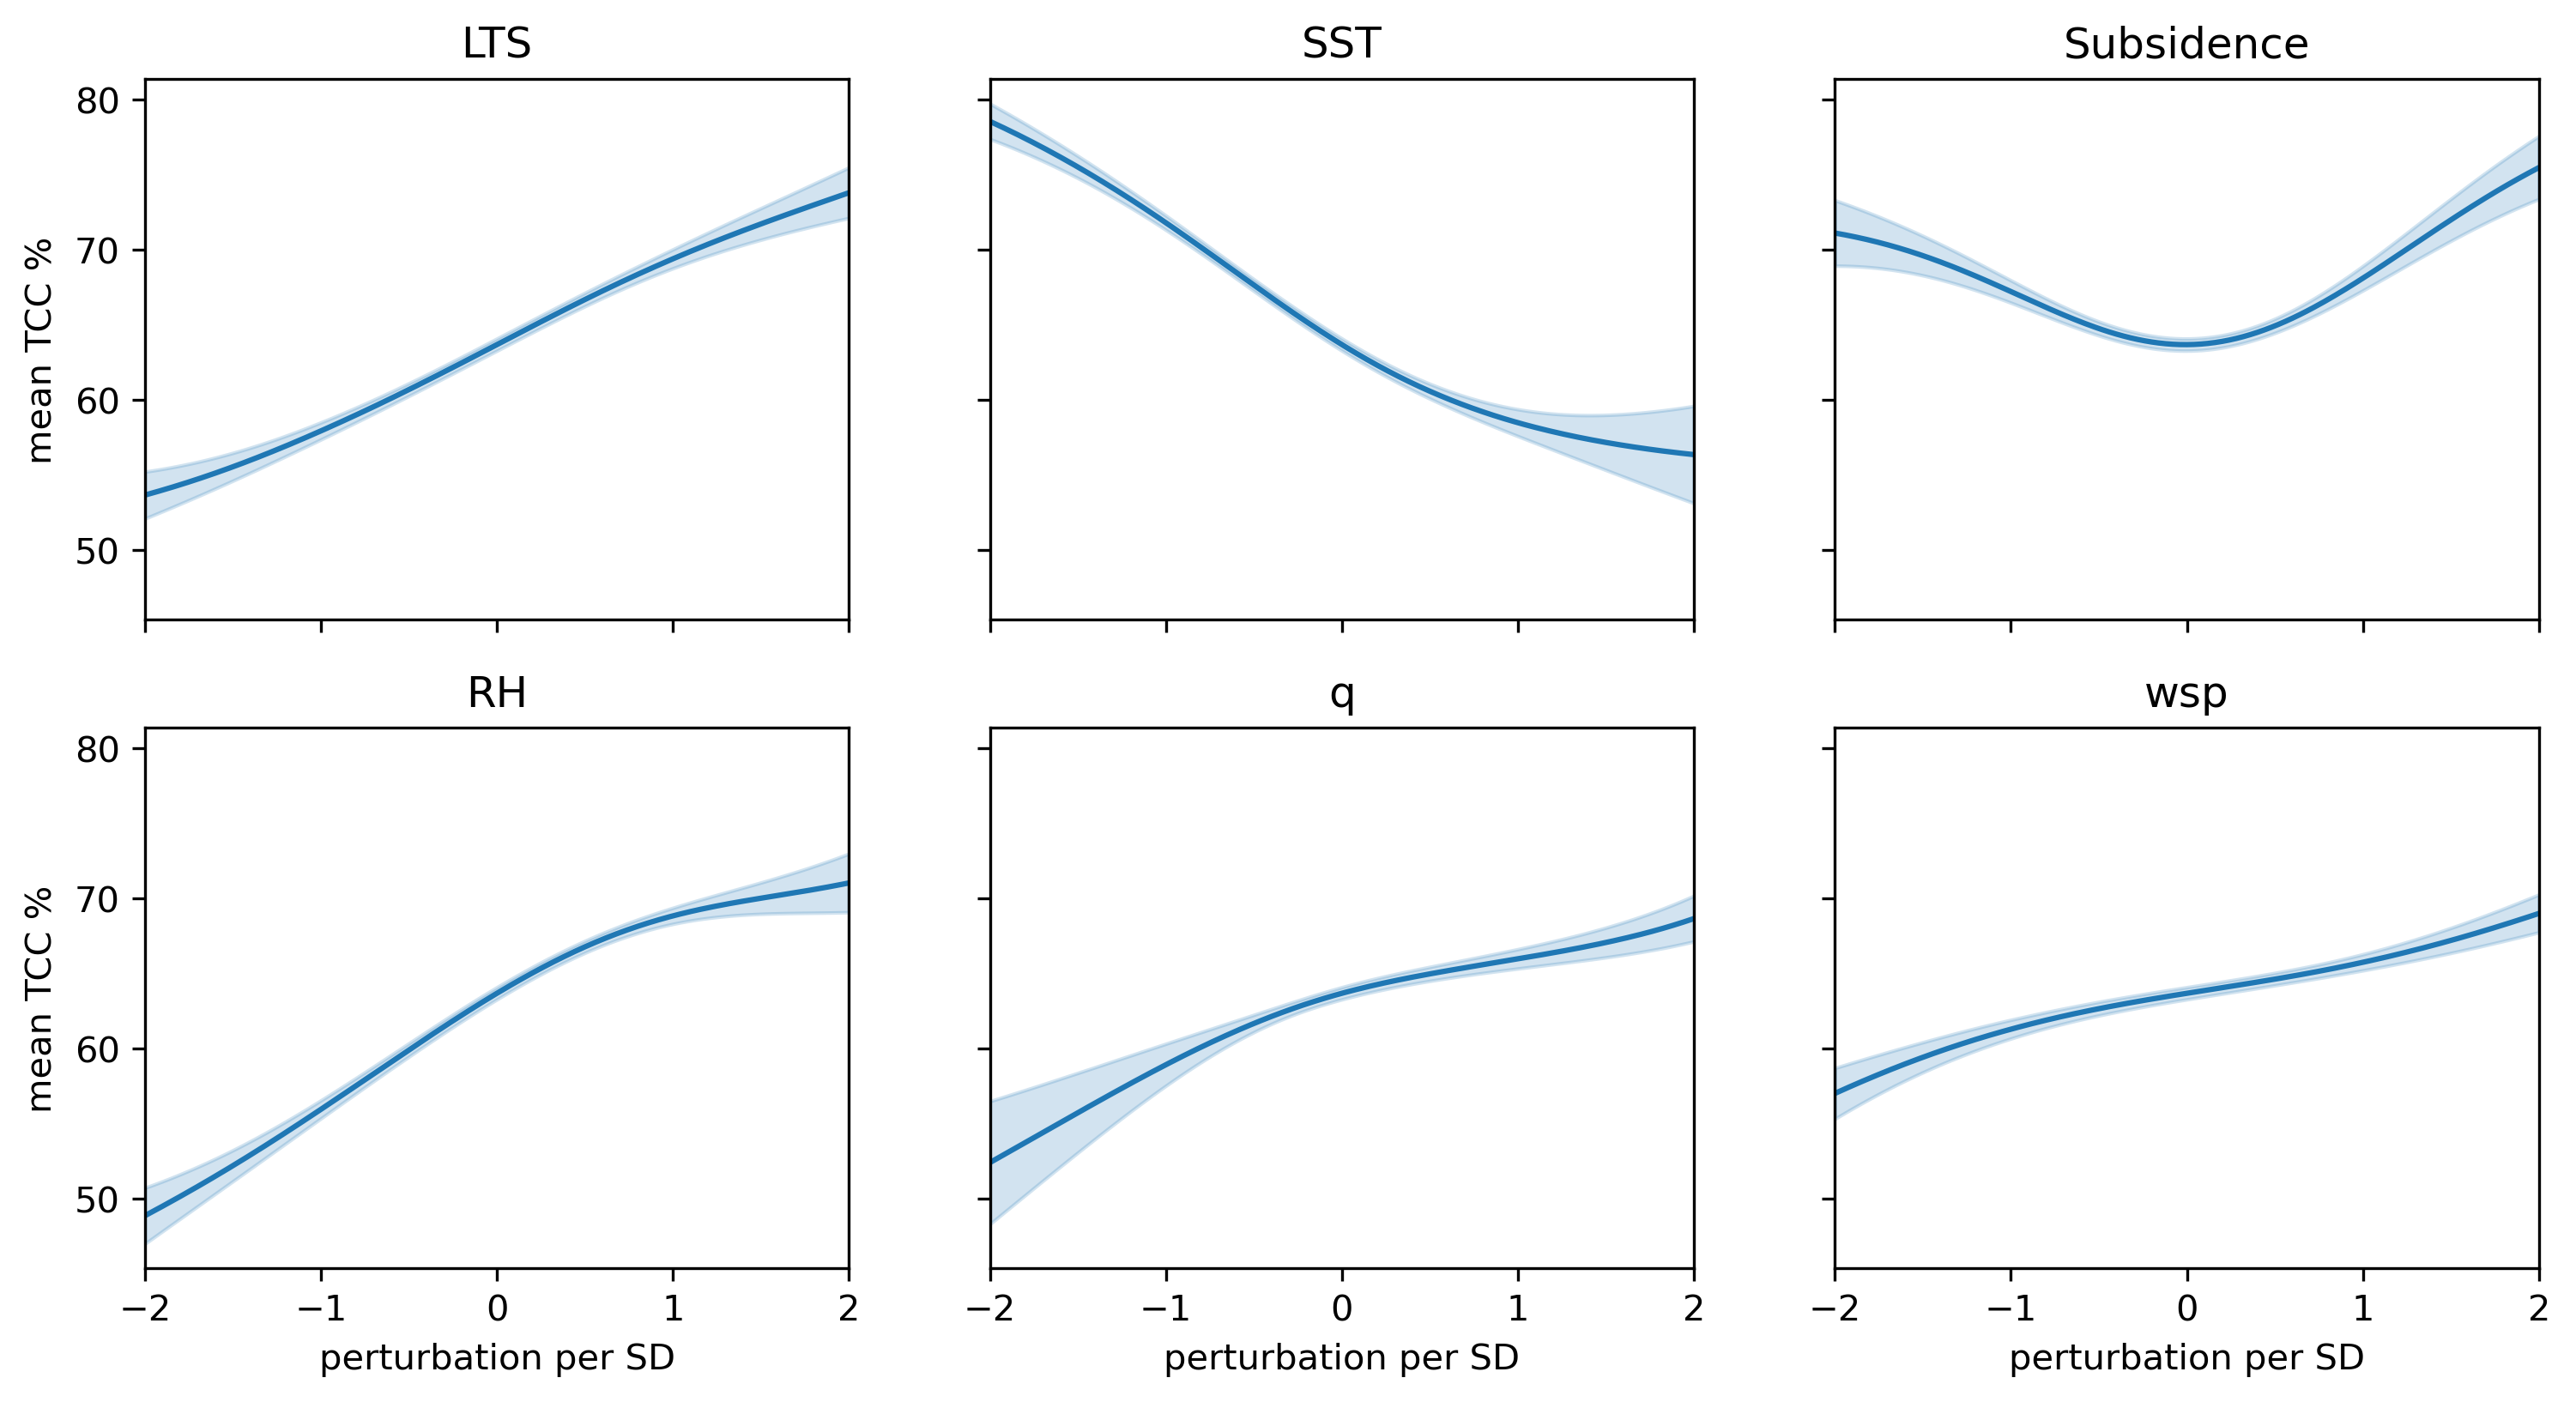

In [16]:
fig, axes = plt.subplots(
    2, 3, 
    sharex=True, 
    sharey=True, 
    figsize=[12, 6]
)

for fig_idx, parameter_name in tqdm(list(enumerate(['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp']))):
    ax=axes[fig_idx//3, fig_idx%3]
    sns.lineplot(
        data=df_stats[parameter_name],
        x="perturbation",
        y="mean",
        ax=axes[fig_idx//3, fig_idx%3],
        errorbar=("sd")
    ).set(
        title=parameter_name,
        ylabel="mean TCC %",
        xlabel="perturbation per SD",
        xlim=[-2, 2]
    )
    
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  9.58it/s]


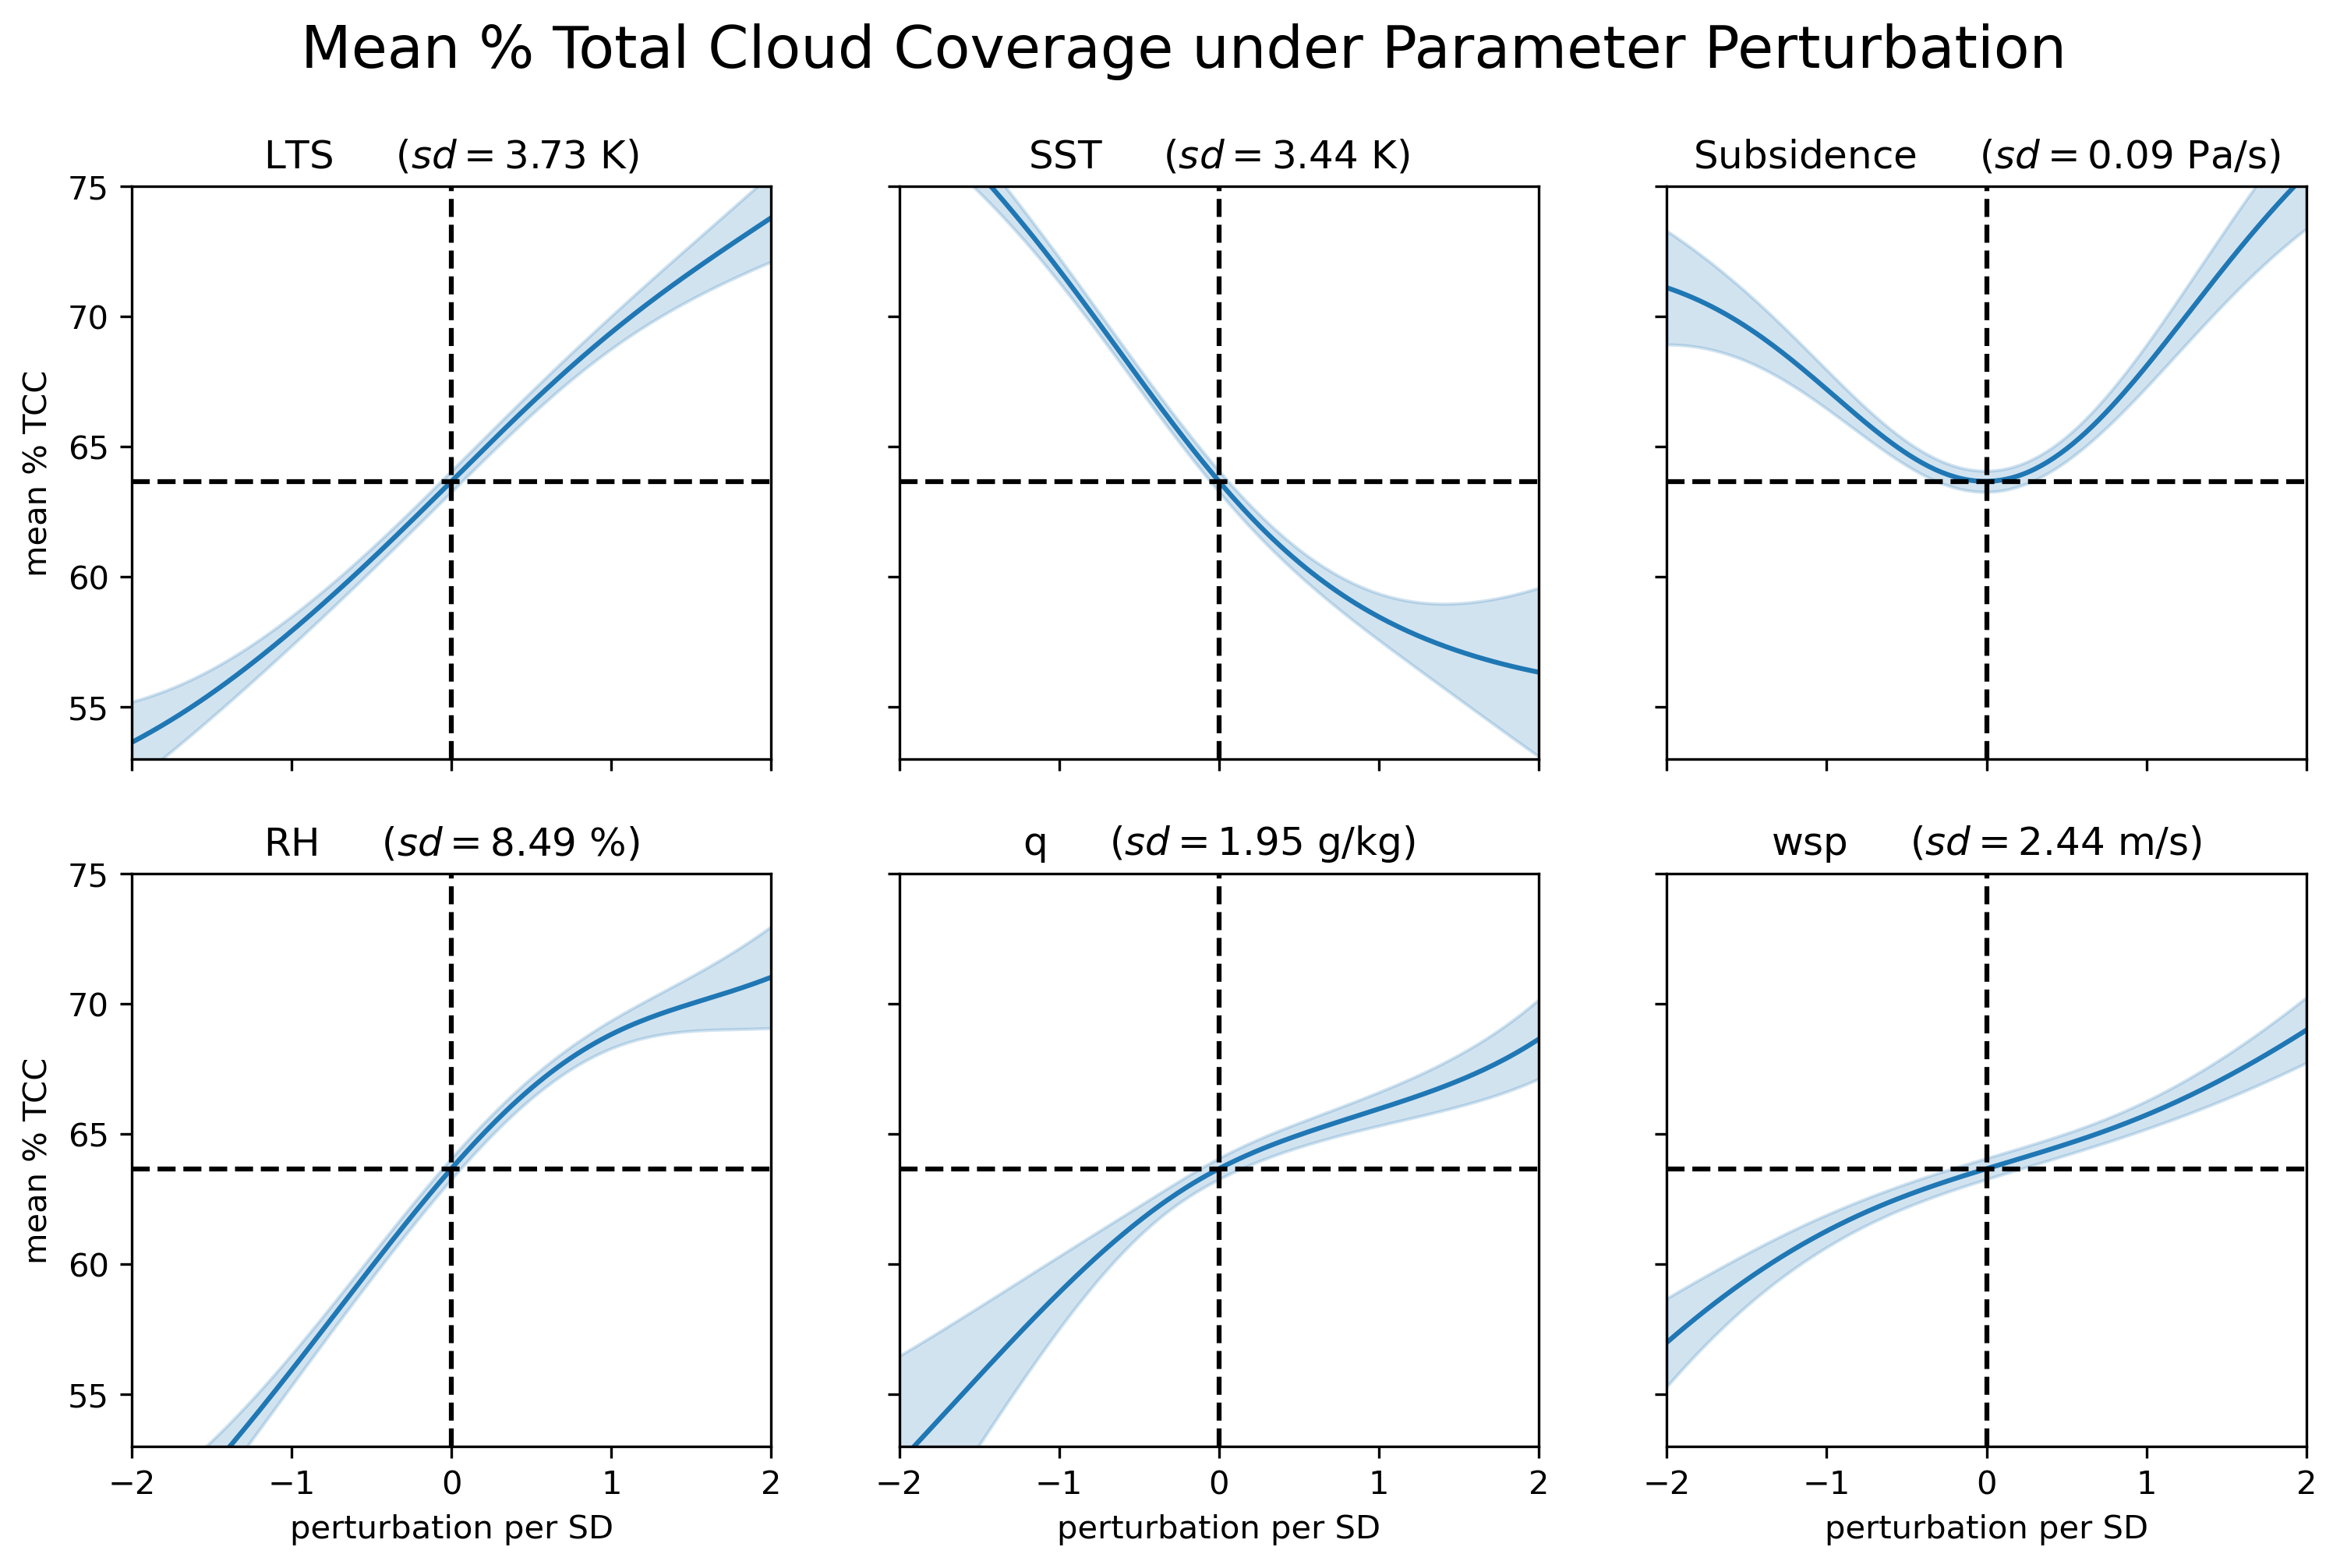

In [17]:
# sns.set(font_scale = 1.3)
# sns.set_style("whitegrid")

fig, axes = plt.subplots(
    2, 3, 
    sharex=True, 
    sharey=True, 
    figsize=[12, 7]
)

for fig_idx, (parameter_name, parameter_unit) in tqdm(list(enumerate(zip(['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp'], ["K", "K", "Pa/s", "%", "g/kg", "m/s"])))):

    ax=axes[fig_idx//3, fig_idx%3]

    df_stat = df_stats[parameter_name]
    y_axhline = np.mean(df_stat[df_stat["perturbation"] == 0]["mean"]) 
    x_axvline = 0
    
    if (parameter_name == "q"):
        plot_title = "{}     ($sd={:.2f}$ {})".format(parameter_name, np.mean(df_stats[parameter_name]["parameter_std"])* 1000, parameter_unit)
    else:
        plot_title = "{}     ($sd={:.2f}$ {})".format(parameter_name, np.mean(df_stats[parameter_name]["parameter_std"]), parameter_unit)
    
    sns.lineplot(
        data=df_stats[parameter_name],
        x="perturbation",
        y="mean",
        ax=axes[fig_idx//3, fig_idx%3],
        errorbar=("sd")
    ).set(
        title=plot_title,
        ylabel="mean % TCC",
        xlabel="perturbation per SD",
        ylim=[53, 75],
        xlim=[-2, 2], 
    )

    ax.axhline(y=y_axhline, color="k", linestyle="--")
    ax.axvline(x=x_axvline, color="k", linestyle="--")

fig.suptitle("Mean % Total Cloud Coverage under Parameter Perturbation", y=.98, fontsize=18)
    
plt.show()




  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  9.73it/s]


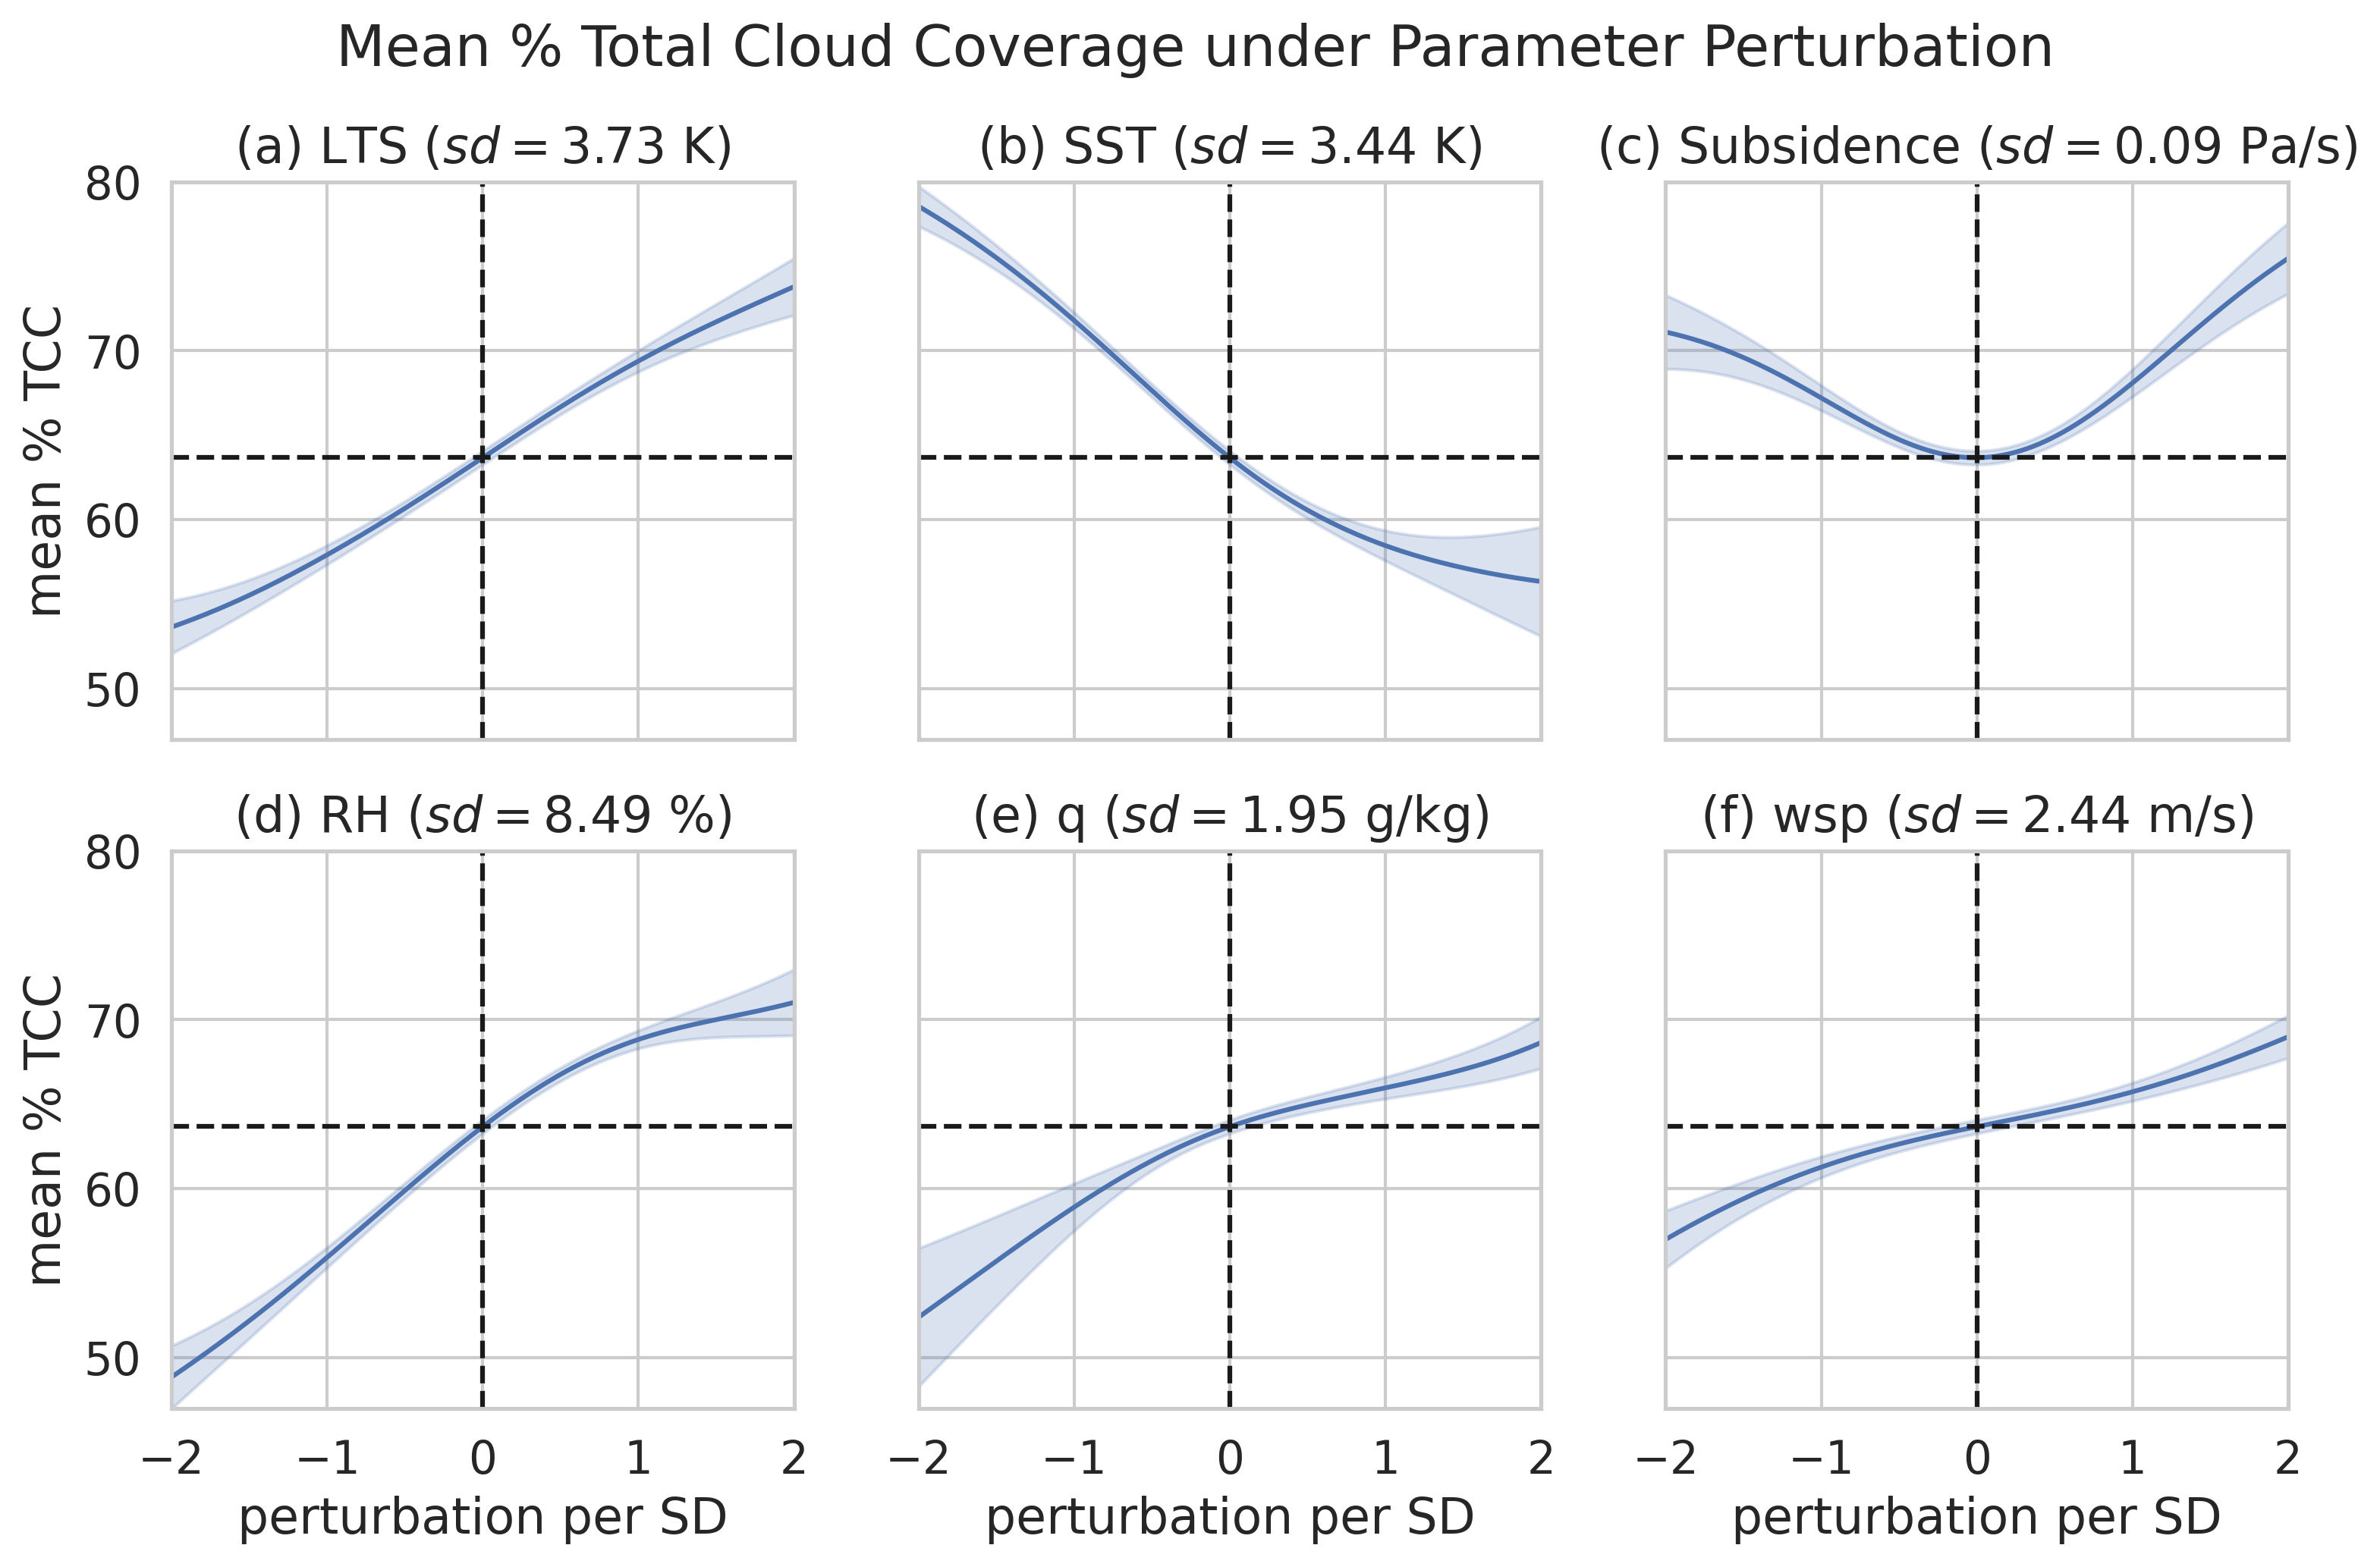

In [ ]:
sns.set(font_scale = 1.3)
sns.set_style("whitegrid")

fig, axes = plt.subplots(
    2, 3, 
    sharex=True, 
    sharey=True, 
    figsize=[12, 7]
)

for fig_idx, (subplot_label, parameter_name, parameter_unit) in tqdm(list(enumerate(zip(["a", "b", "c", "d", "e", "f"], ['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp'], ["K", "K", "Pa/s", "%", "g/kg", "m/s"])))):

    ax=axes[fig_idx//3, fig_idx%3]

    df_stat = df_stats[parameter_name]
    y_axhline = np.mean(df_stat[df_stat["perturbation"] == 0]["mean"]) 
    x_axvline = 0
    
    if (parameter_name == "q"):
        plot_title = "({}) {} ($sd={:.2f}$ {})".format(subplot_label, parameter_name, np.mean(df_stats[parameter_name]["parameter_std"])* 1000, parameter_unit)
    else:
        plot_title = "({}) {} ($sd={:.2f}$ {})".format(subplot_label, parameter_name, np.mean(df_stats[parameter_name]["parameter_std"]), parameter_unit)
    
    sns.lineplot(
        data=df_stats[parameter_name],
        x="perturbation",
        y="mean",
        ax=axes[fig_idx//3, fig_idx%3],
        errorbar=("sd")
    ).set(
        title=plot_title,
        ylabel="mean % TCC",
        xlabel="perturbation per SD",
        ylim=[47, 80],
        xlim=[-2, 2], 
    )

    ax.axhline(y=y_axhline, color="k", linestyle="--")
    ax.axvline(x=x_axvline, color="k", linestyle="--")

fig.suptitle("Mean % Total Cloud Coverage under Parameter Perturbation", y=.98, fontsize=16)
    
plt.show()




100%|██████████| 6/6 [00:00<00:00,  9.34it/s]


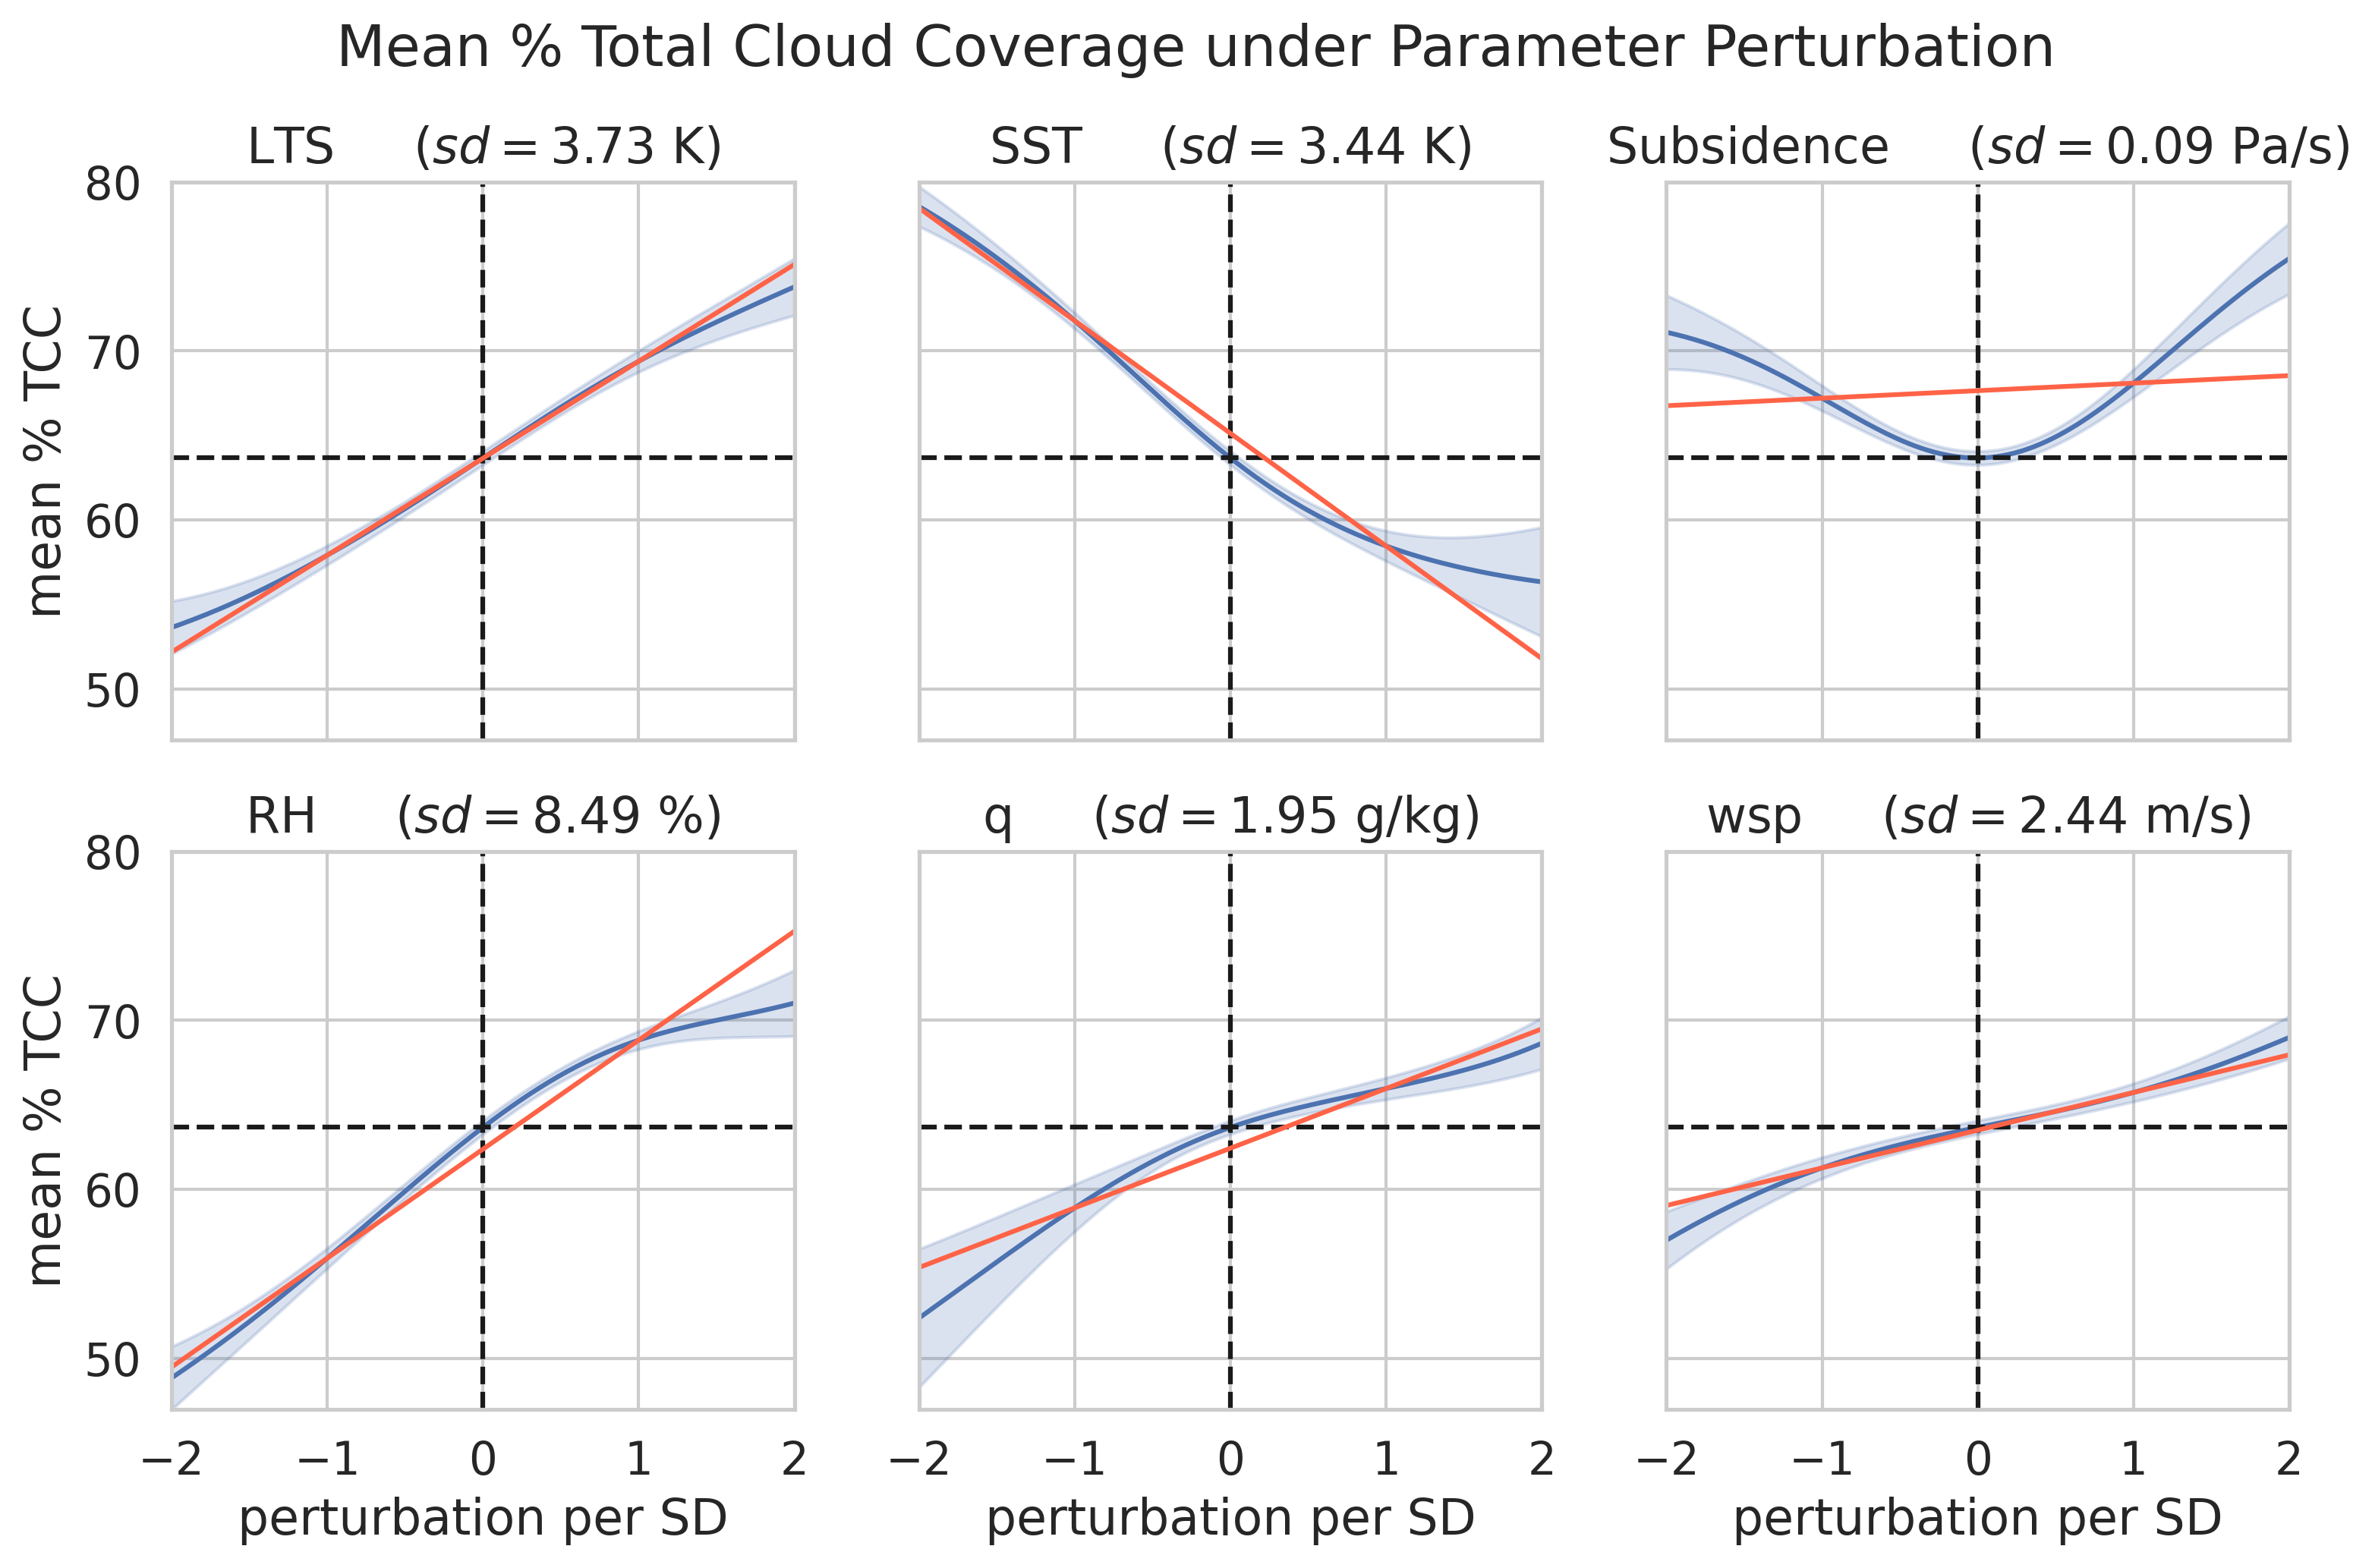

In [50]:
# sns.set(font_scale = 1.3)
# sns.set_style("whitegrid")

fig, axes = plt.subplots(
    2, 3, 
    sharex=True, 
    sharey=True, 
    figsize=[12, 7]
)

for fig_idx, (parameter_name, parameter_unit) in tqdm(list(enumerate(zip(['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp'], ["K", "K", "Pa/s", "%", "g/kg", "m/s"])))):

    ax=axes[fig_idx//3, fig_idx%3]

    df_stat = df_stats[parameter_name]
    y_axhline = np.mean(df_stat[df_stat["perturbation"] == 0]["mean"]) 
    x_axvline = 0
    
    if (parameter_name == "q"):
        plot_title = "{}     ($sd={:.2f}$ {})".format(parameter_name, np.mean(df_stats[parameter_name]["parameter_std"])* 1000, parameter_unit)
    else:
        plot_title = "{}     ($sd={:.2f}$ {})".format(parameter_name, np.mean(df_stats[parameter_name]["parameter_std"]), parameter_unit)
    
    sns.lineplot(
        data=df_stats[parameter_name],
        x="perturbation",
        y="mean",
        ax=axes[fig_idx//3, fig_idx%3],
        errorbar=("sd"),
    ).set(
        title=plot_title,
        ylabel="mean % TCC",
        xlabel="perturbation per SD",
        ylim=[47, 80],
        xlim=[-2, 2], 
    )

    ax.axhline(y=y_axhline, color="k", linestyle="--")
    ax.axvline(x=x_axvline, color="k", linestyle="--")
    
    df_stat_1sd = df_stat[(-1 == df_stat["perturbation"]) | (df_stat["perturbation"] == 1)]
    x_plot = np.linspace(-2, 2, 100)
    y_linear_fit = np.polyval(np.polyfit(df_stat_1sd["perturbation"], df_stat_1sd["mean"], 1), x_plot)
    
    ax.plot(x_plot, y_linear_fit, color="tomato")
    

fig.suptitle("Mean % Total Cloud Coverage under Parameter Perturbation", y=.98, fontsize=18)
# fig.suptitle("Mean % Total Cloud Coverage under Parameter Perturbation", y=.98)
plt.show()




100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


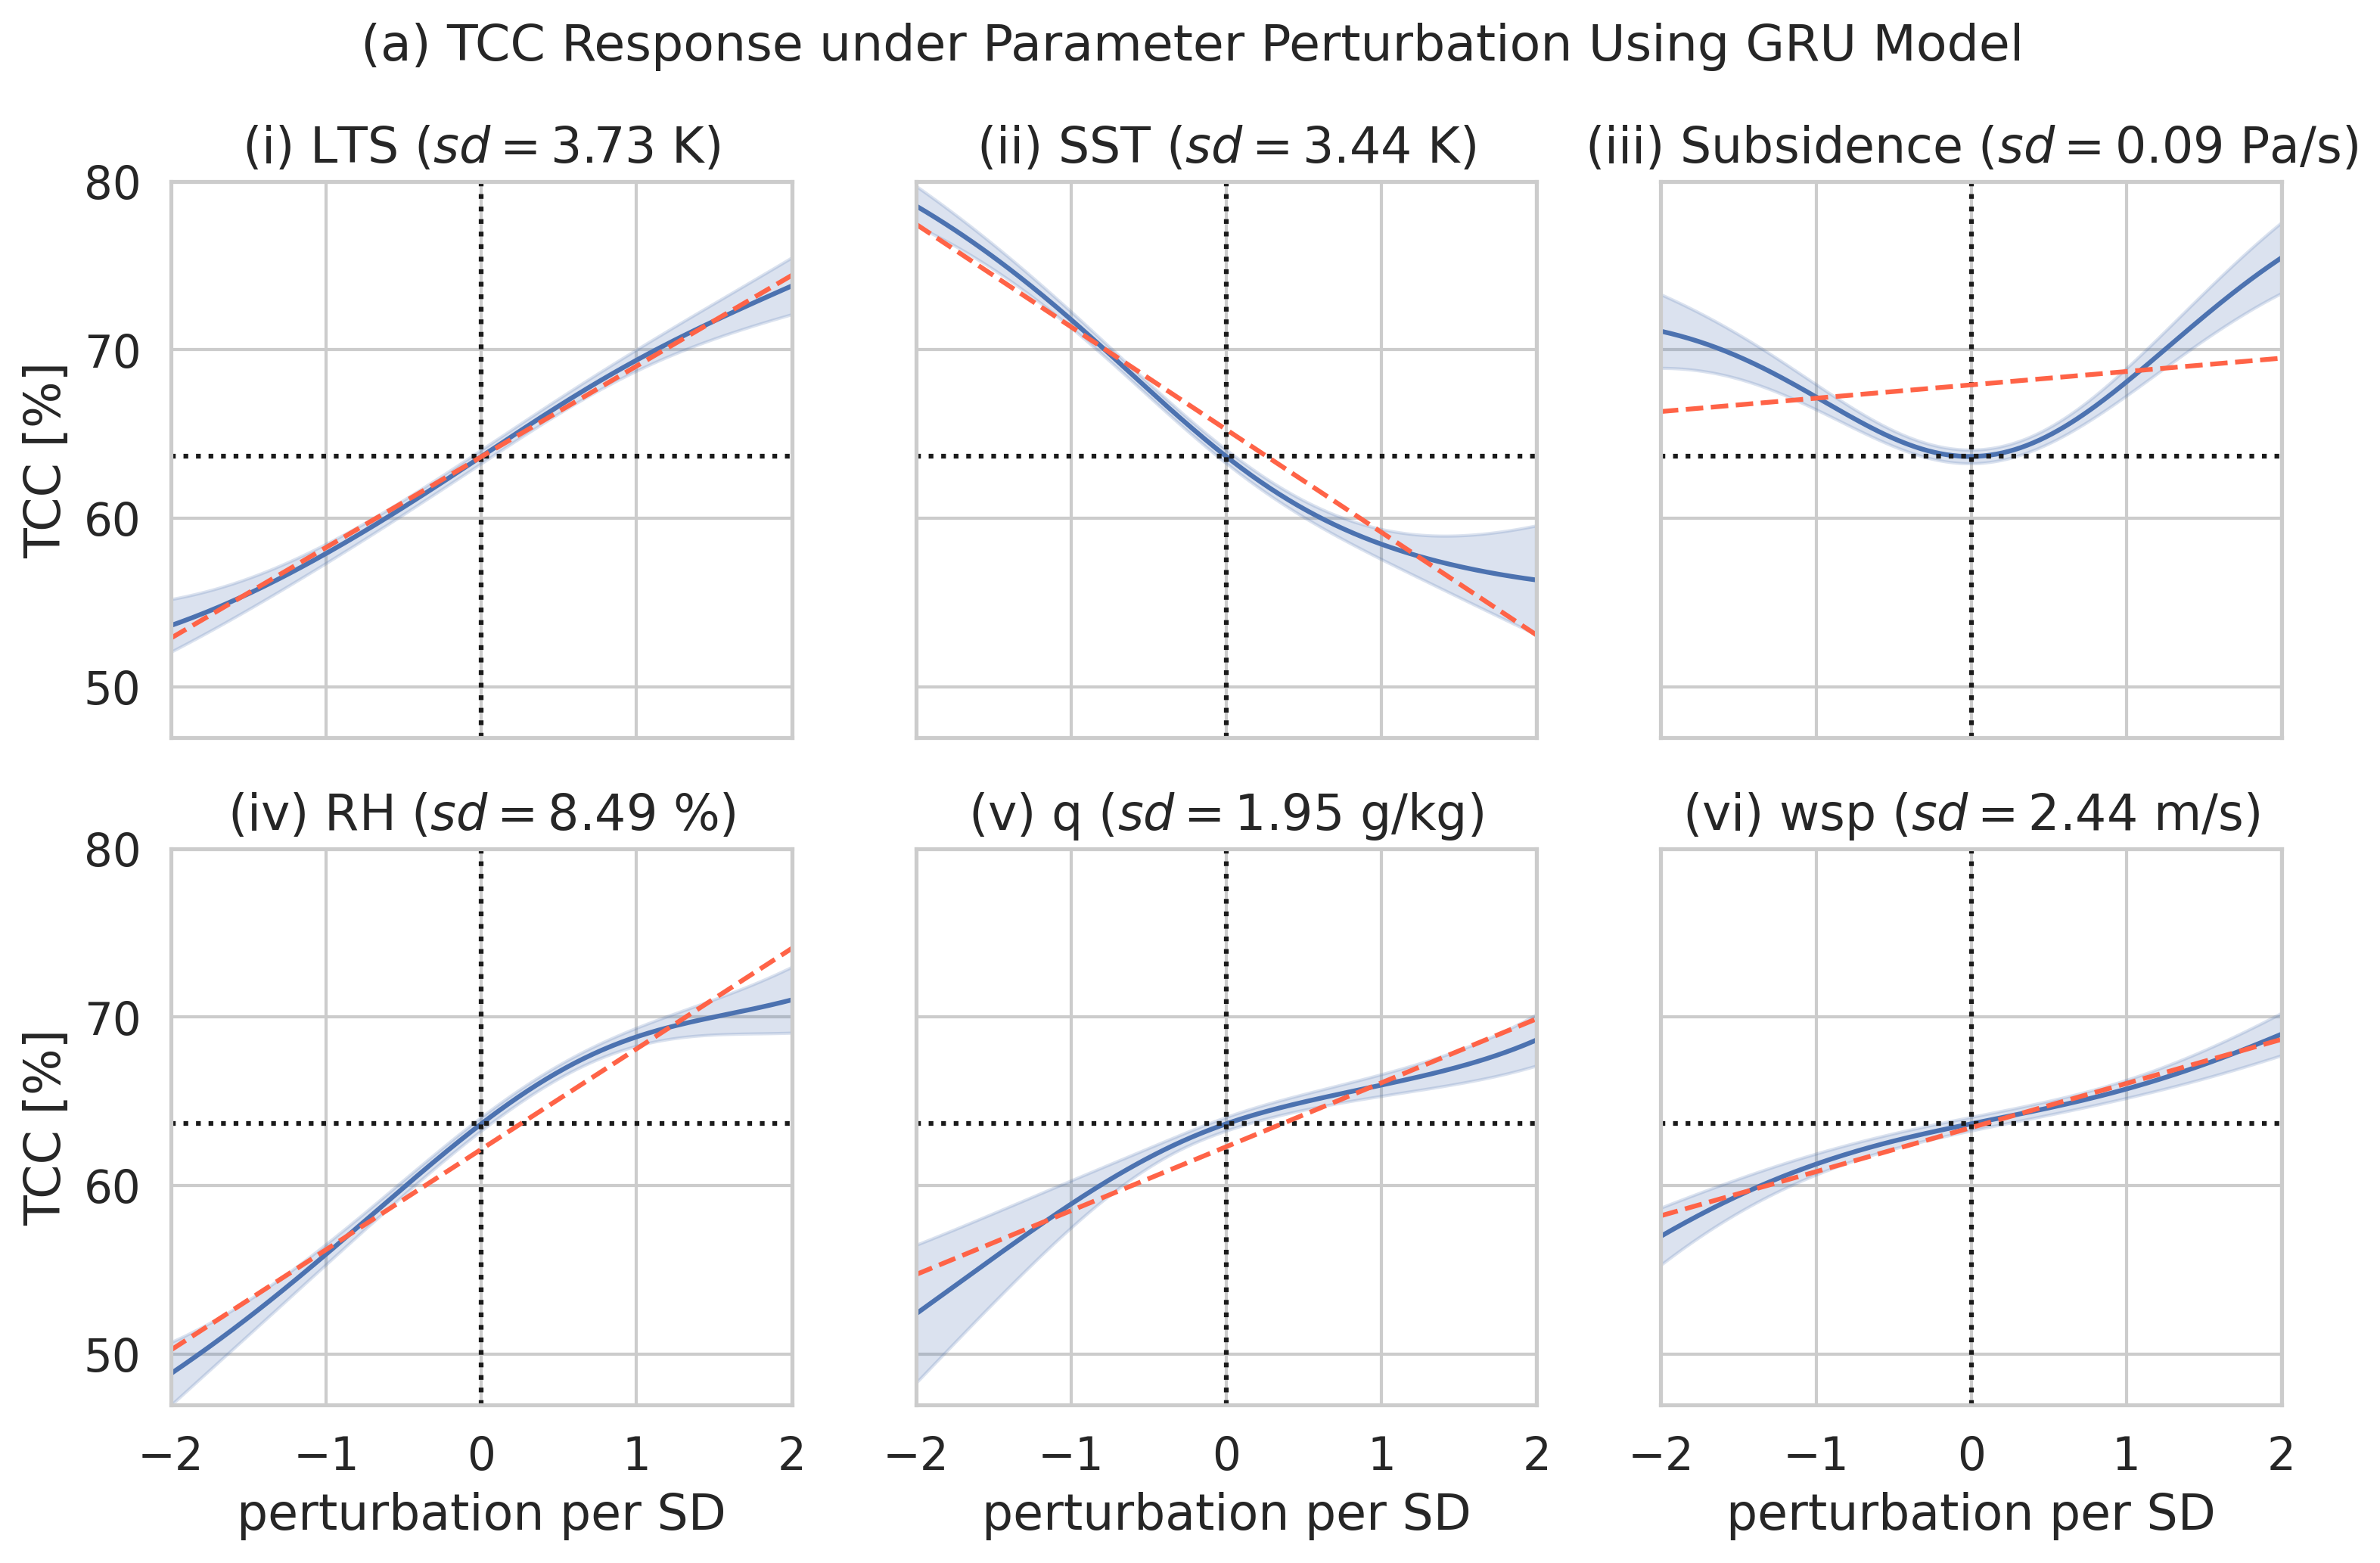

In [55]:
# sns.set(font_scale = 1.3)
# sns.set_style("whitegrid")

fig, axes = plt.subplots(
    2, 3, 
    sharex=True, 
    sharey=True, 
    figsize=[12, 7]
)

for fig_idx, (subplot_label, parameter_name, parameter_unit) in tqdm(list(enumerate(zip(["i", "ii", "iii", "iv", "v", "vi"], ['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp'], ["K", "K", "Pa/s", "%", "g/kg", "m/s"])))):

    ax=axes[fig_idx//3, fig_idx%3]

    df_stat = df_stats[parameter_name]
    y_axhline = np.mean(df_stat[df_stat["perturbation"] == 0]["mean"]) 
    x_axvline = 0
    
    if (parameter_name == "q"):
        plot_title = "({}) {} ($sd={:.2f}$ {})".format(subplot_label, parameter_name, np.mean(df_stats[parameter_name]["parameter_std"])* 1000, parameter_unit)
    else:
        plot_title = "({}) {} ($sd={:.2f}$ {})".format(subplot_label, parameter_name, np.mean(df_stats[parameter_name]["parameter_std"]), parameter_unit)
    
    sns.lineplot(
        data=df_stats[parameter_name],
        x="perturbation",
        y="mean",
        ax=axes[fig_idx//3, fig_idx%3],
        errorbar=("sd")
    ).set(
        title=plot_title,
        ylabel="TCC [%]",
        xlabel="perturbation per SD",
        ylim=[47, 80],
        xlim=[-2, 2], 
    )
    
    ax.axhline(y=y_axhline, color="k", linestyle="dotted")
    ax.axvline(x=x_axvline, color="k", linestyle="dotted")
    
    df_stat_1sd = df_stat[(-2 >= df_stat["perturbation"]) | (df_stat["perturbation"] <= 2)]
    x_plot = np.linspace(-2, 2, 100)
    y_linear_fit = np.polyval(np.polyfit(df_stat_1sd["perturbation"], df_stat_1sd["mean"], 1), x_plot)
    
    ax.plot(x_plot, y_linear_fit, color="tomato", linestyle="dashed")
    

# fig.suptitle("(a) TCC Response under Parameter Perturbation Using GRU Model", y=.98, fontsize=18)
fig.suptitle("(a) TCC Response under Parameter Perturbation Using GRU Model", y=.98, fontsize=16)
plt.show()




In [21]:
df_stats["LTS"]

perturbation  parameter_std        min  percentile25       mean  \
0              -2.0       3.682160   6.577526     39.047671  52.556475   
1              -2.0       3.706011 -11.988908     46.055955  57.365384   
2              -2.0       3.681589   3.743102     42.221441  53.963960   
3              -2.0       3.752310  -2.121454     36.097321  51.351260   
4              -2.0       3.752504   3.686923     42.277705  55.876629   
...             ...            ...        ...           ...        ...   
40195           2.0       3.696356  -7.252195     68.997433  76.635550   
40196           2.0       3.727664 -17.256621     65.312702  75.047973   
40197           2.0       3.720457   6.059374     66.398826  75.473405   
40198           2.0       3.705992  -1.723983     63.084888  73.450197   
40199           2.0       3.710447  -9.782329     61.470185  72.562667   

       percentile75         max        std  
0         64.877293   96.308613  18.550513  
1         69.603904   97.206437  16.555118  
2         65.368447  102.007469  16.656404  
3         67.922349   96.229406  20.645427  
4         69.047450   97.780050  18.211251  
...             ...         ...        ...  
40195     87.240629   99.611192  15.041478  
40196     88.262408   98.982714  15.786575  
40197     87.011218   97.888296  15.275173  
40198     86.849090  100.346597  15.968794  
40199     86.450603   99.338486  16.407603  

[40200 rows x 8 columns]

In [22]:
pd.DataFrame([
    {
        "parameter_name": parameter_name, 
        "slope": np.polyfit(df_stats[parameter_name]["perturbation"], df_stats[parameter_name]["mean"], 1)[0]
    }
    for parameter_name in ['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp']
])

parameter_name     slope
0            LTS  5.381511
1            SST -6.097701
2     Subsidence  0.791988
3             RH  5.957275
4              q  3.794750
5            wsp  2.617501

In [23]:
print(
    tabulate.tabulate(
        [
            {
                "parameter_name": parameter_name, 
                "slope": np.polyfit(df_stats[parameter_name]["perturbation"], df_stats[parameter_name]["mean"], 1)[0]
            }
            for parameter_name in ['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp']
        ],
        headers="keys",
        floatfmt=".2f"
    )
)


parameter_name      slope
----------------  -------
LTS                  5.38
SST                 -6.10
Subsidence           0.79
RH                   5.96
q                    3.79
wsp                  2.62


In [24]:
pd.DataFrame(
    [
        dict(
            sample_idx=sample_idx,
            parameter_name=PARAMETER_NAMES[parameter_idx],
            perturbation_per_sd=raw_stats[parameter_idx][perturbation_idx][sample_idx]["perturbation"],
            pertubation=raw_stats[parameter_idx][perturbation_idx][sample_idx]["parameter_std"] * raw_stats[parameter_idx][perturbation_idx][sample_idx]["perturbation"],
            mean=raw_stats[parameter_idx][perturbation_idx][sample_idx]["mean"],
        )
        for parameter_idx in np.arange(len(raw_stats))
        for perturbation_idx in np.arange(len(raw_stats[0]))
        for sample_idx in np.arange(len(raw_stats[0][0]))
        if PARAMETER_NAMES[parameter_idx] in ['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp']
    ]
)

sample_idx parameter_name  perturbation_per_sd  pertubation       mean
0                0            LTS                 -2.0    -7.364320  52.556475
1                1            LTS                 -2.0    -7.412022  57.365384
2                2            LTS                 -2.0    -7.363178  53.963960
3                3            LTS                 -2.0    -7.504619  51.351260
4                4            LTS                 -2.0    -7.505009  55.876629
...            ...            ...                  ...          ...        ...
241195         195            wsp                  2.0     4.864802  69.464459
241196         196            wsp                  2.0     4.895677  68.281524
241197         197            wsp                  2.0     4.898604  69.939549
241198         198            wsp                  2.0     4.875683  68.864310
241199         199            wsp                  2.0     4.843556  68.428896

[241200 rows x 5 columns]

In [25]:
parameter_slope = [
    dict(
        parameter_name = PARAMETER_NAMES[parameter_idx],
        parameter_sd = np.mean([
            [
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["parameter_std"]
                for sample_idx in np.arange(len(raw_stats[0][0]))
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ]
        ]),
        slope = np.polyfit(
            x=[
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["parameter_std"] * raw_stats[parameter_idx][perturbation_idx][sample_idx]["perturbation"]
                for sample_idx in np.arange(len(raw_stats[0][0]))
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ],
            y=[
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["mean"]
                for sample_idx in np.arange(len(raw_stats[0][0]))
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ],
            deg=1
        )[0],
        per_sd_slope = np.polyfit(
            x=[
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["perturbation"]
                for sample_idx in np.arange(len(raw_stats[0][0]))
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ],
            y=[
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["mean"]
                for sample_idx in np.arange(len(raw_stats[0][0]))
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ],
            deg=1
        )[0]
    )
    
    for parameter_idx in np.arange(len(raw_stats))
    if PARAMETER_NAMES[parameter_idx] in ['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp']
]

In [26]:
parameter_slope[-2]["parameter_sd"] *= 1000
parameter_slope[-2]["slope"] /= 1000

In [27]:
parameter_slope

[{'parameter_name': 'LTS',
  'parameter_sd': 3.7270439179042882,
  'slope': 1.4437608009066865,
  'per_sd_slope': 5.381510918922964},
 {'parameter_name': 'SST',
  'parameter_sd': 3.4435698257639524,
  'slope': -1.7706280388431084,
  'per_sd_slope': -6.097701150584525},
 {'parameter_name': 'Subsidence',
  'parameter_sd': 0.08736042587408327,
  'slope': 9.067853151193617,
  'per_sd_slope': 0.791988483141614},
 {'parameter_name': 'RH',
  'parameter_sd': 8.485584259916356,
  'slope': 0.702052266083331,
  'per_sd_slope': 5.957274815177964},
 {'parameter_name': 'q',
  'parameter_sd': 1.9502988969229516,
  'slope': 1.9460510853299755,
  'per_sd_slope': 3.7947501665120695},
 {'parameter_name': 'wsp',
  'parameter_sd': 2.441313477970289,
  'slope': 1.0721251629258617,
  'per_sd_slope': 2.617501209506833}]

In [28]:
print(tabulate.tabulate(
    parameter_slope, 
    headers="keys",
    floatfmt=".3f"
))

parameter_name      parameter_sd    slope    per_sd_slope
----------------  --------------  -------  --------------
LTS                        3.727    1.444           5.382
SST                        3.444   -1.771          -6.098
Subsidence                 0.087    9.068           0.792
RH                         8.486    0.702           5.957
q                          1.950    1.946           3.795
wsp                        2.441    1.072           2.618


In [29]:
print(tabulate.tabulate(
    parameter_slope, 
    headers="keys",
    floatfmt=".3f"
))

parameter_name      parameter_sd    slope    per_sd_slope
----------------  --------------  -------  --------------
LTS                        3.727    1.444           5.382
SST                        3.444   -1.771          -6.098
Subsidence                 0.087    9.068           0.792
RH                         8.486    0.702           5.957
q                          1.950    1.946           3.795
wsp                        2.441    1.072           2.618


In [30]:
df_parameter_slope_by_sample = pd.DataFrame([
    dict(
        parameter_name = PARAMETER_NAMES[parameter_idx],
        parameter_sd = np.mean([
            [
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["parameter_std"]
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ]
        ]),
        slope = np.polyfit(
            x=[
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["parameter_std"] * raw_stats[parameter_idx][perturbation_idx][sample_idx]["perturbation"]
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ],
            y=[
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["mean"]
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ],
            deg=1
        )[0],
        per_sd_slope = np.polyfit(
            x=[
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["perturbation"]
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ],
            y=[
                raw_stats[parameter_idx][perturbation_idx][sample_idx]["mean"]
                for perturbation_idx in np.arange(len(raw_stats[0]))
            ],
            deg=1
        )[0]
    )
    for sample_idx in np.arange(len(raw_stats[0][0]))
    for parameter_idx in np.arange(len(raw_stats))
    if PARAMETER_NAMES[parameter_idx] in ['LTS', 'SST', 'Subsidence', 'RH', 'q', 'wsp']
])

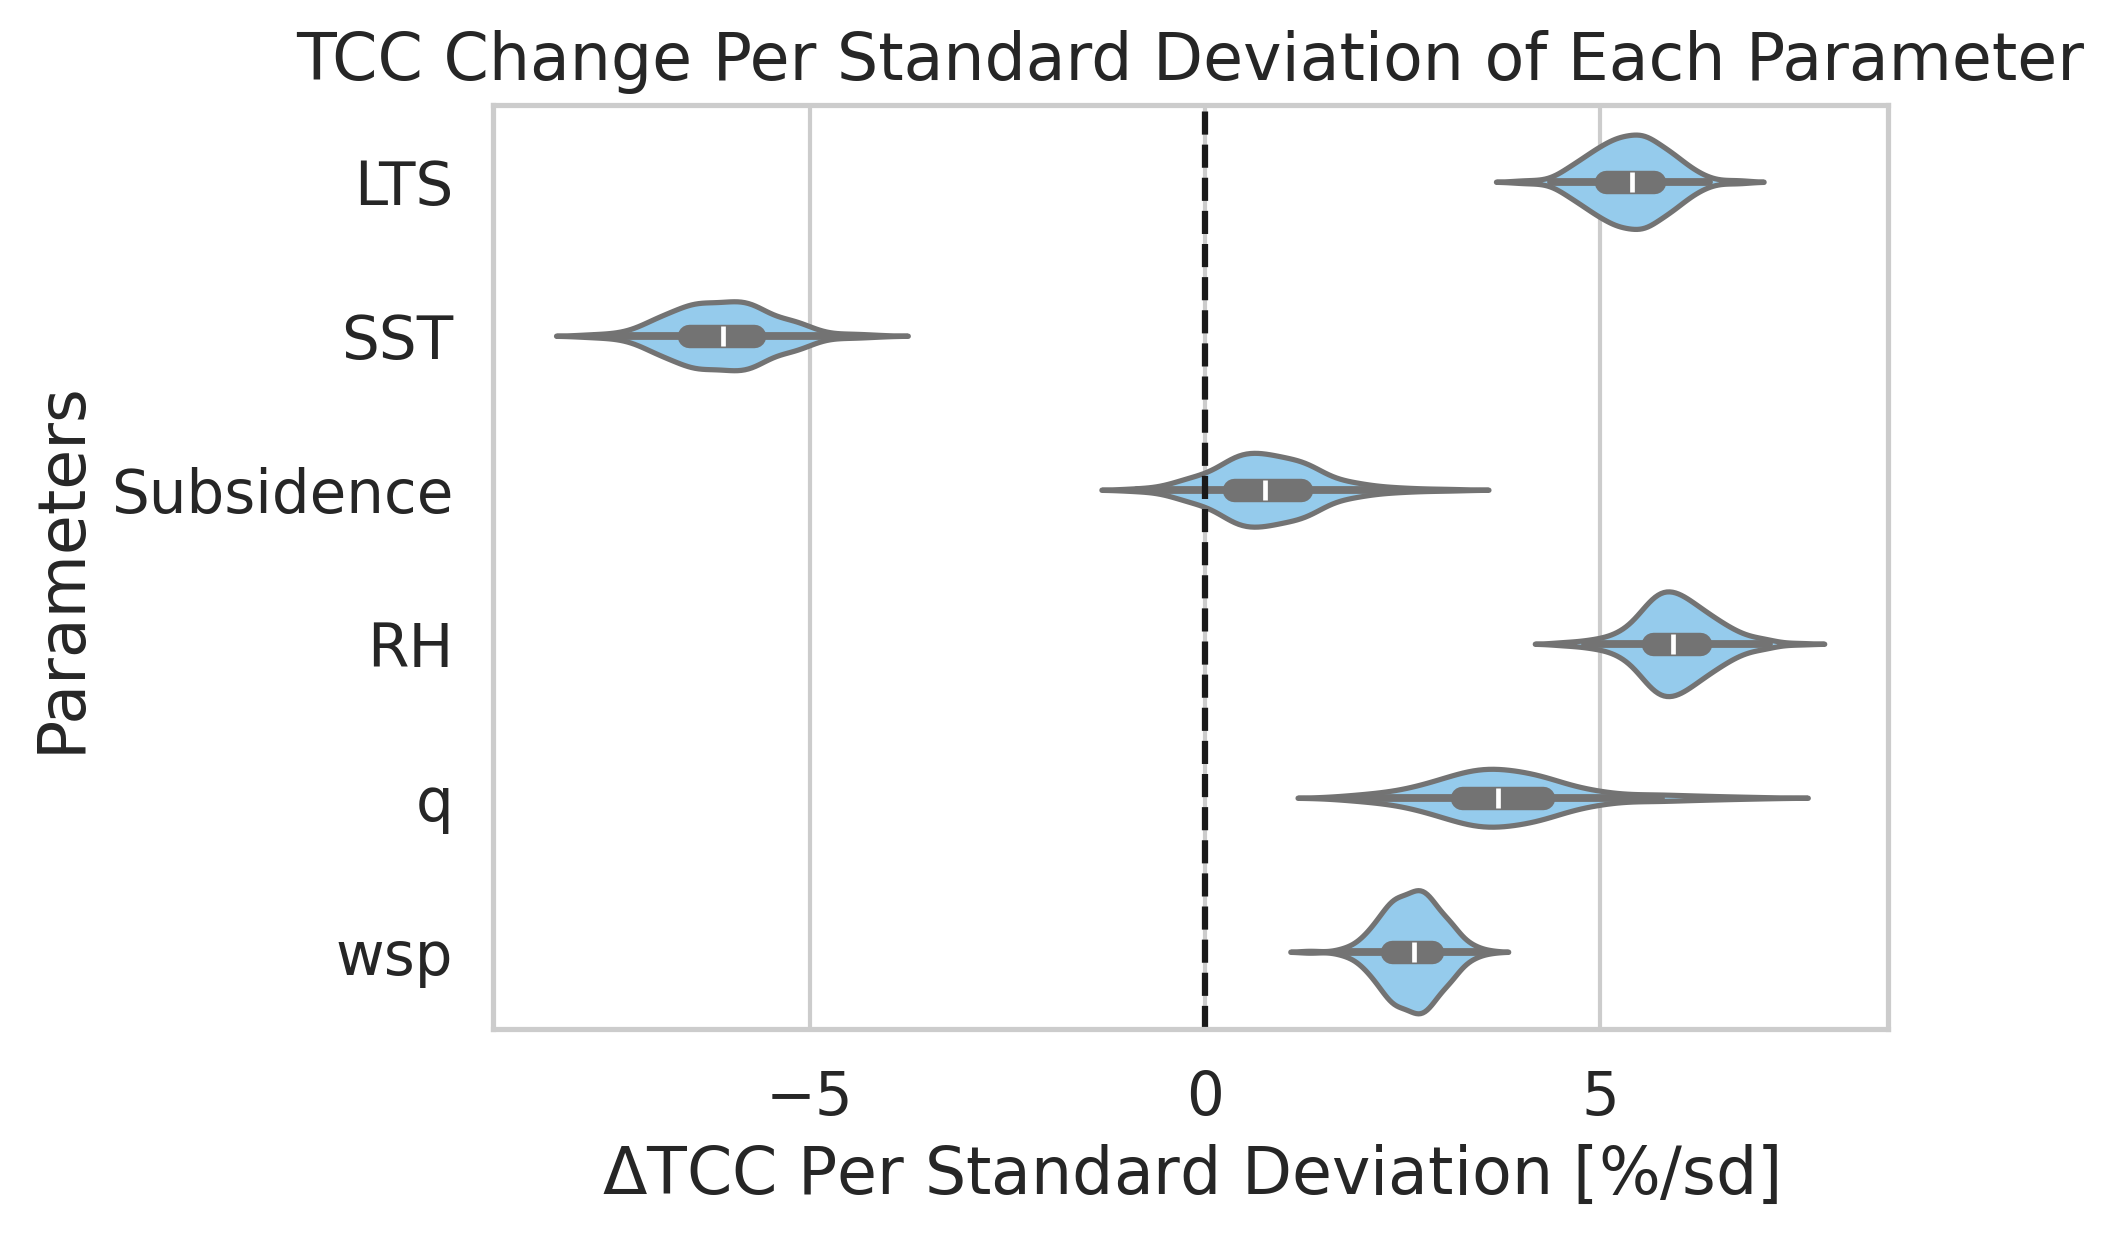

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.violinplot(
    data=df_parameter_slope_by_sample,
    x="per_sd_slope",
    y="parameter_name",
    color="lightskyblue"
)
ax.axvline(x=0, color="k", linestyle="--")
ax.set(
    ylabel="Parameters",
    xlabel="$\Delta$TCC Per Standard Deviation [%/sd]",
    title="TCC Change Per Standard Deviation of Each Parameter"
)
plt.show()

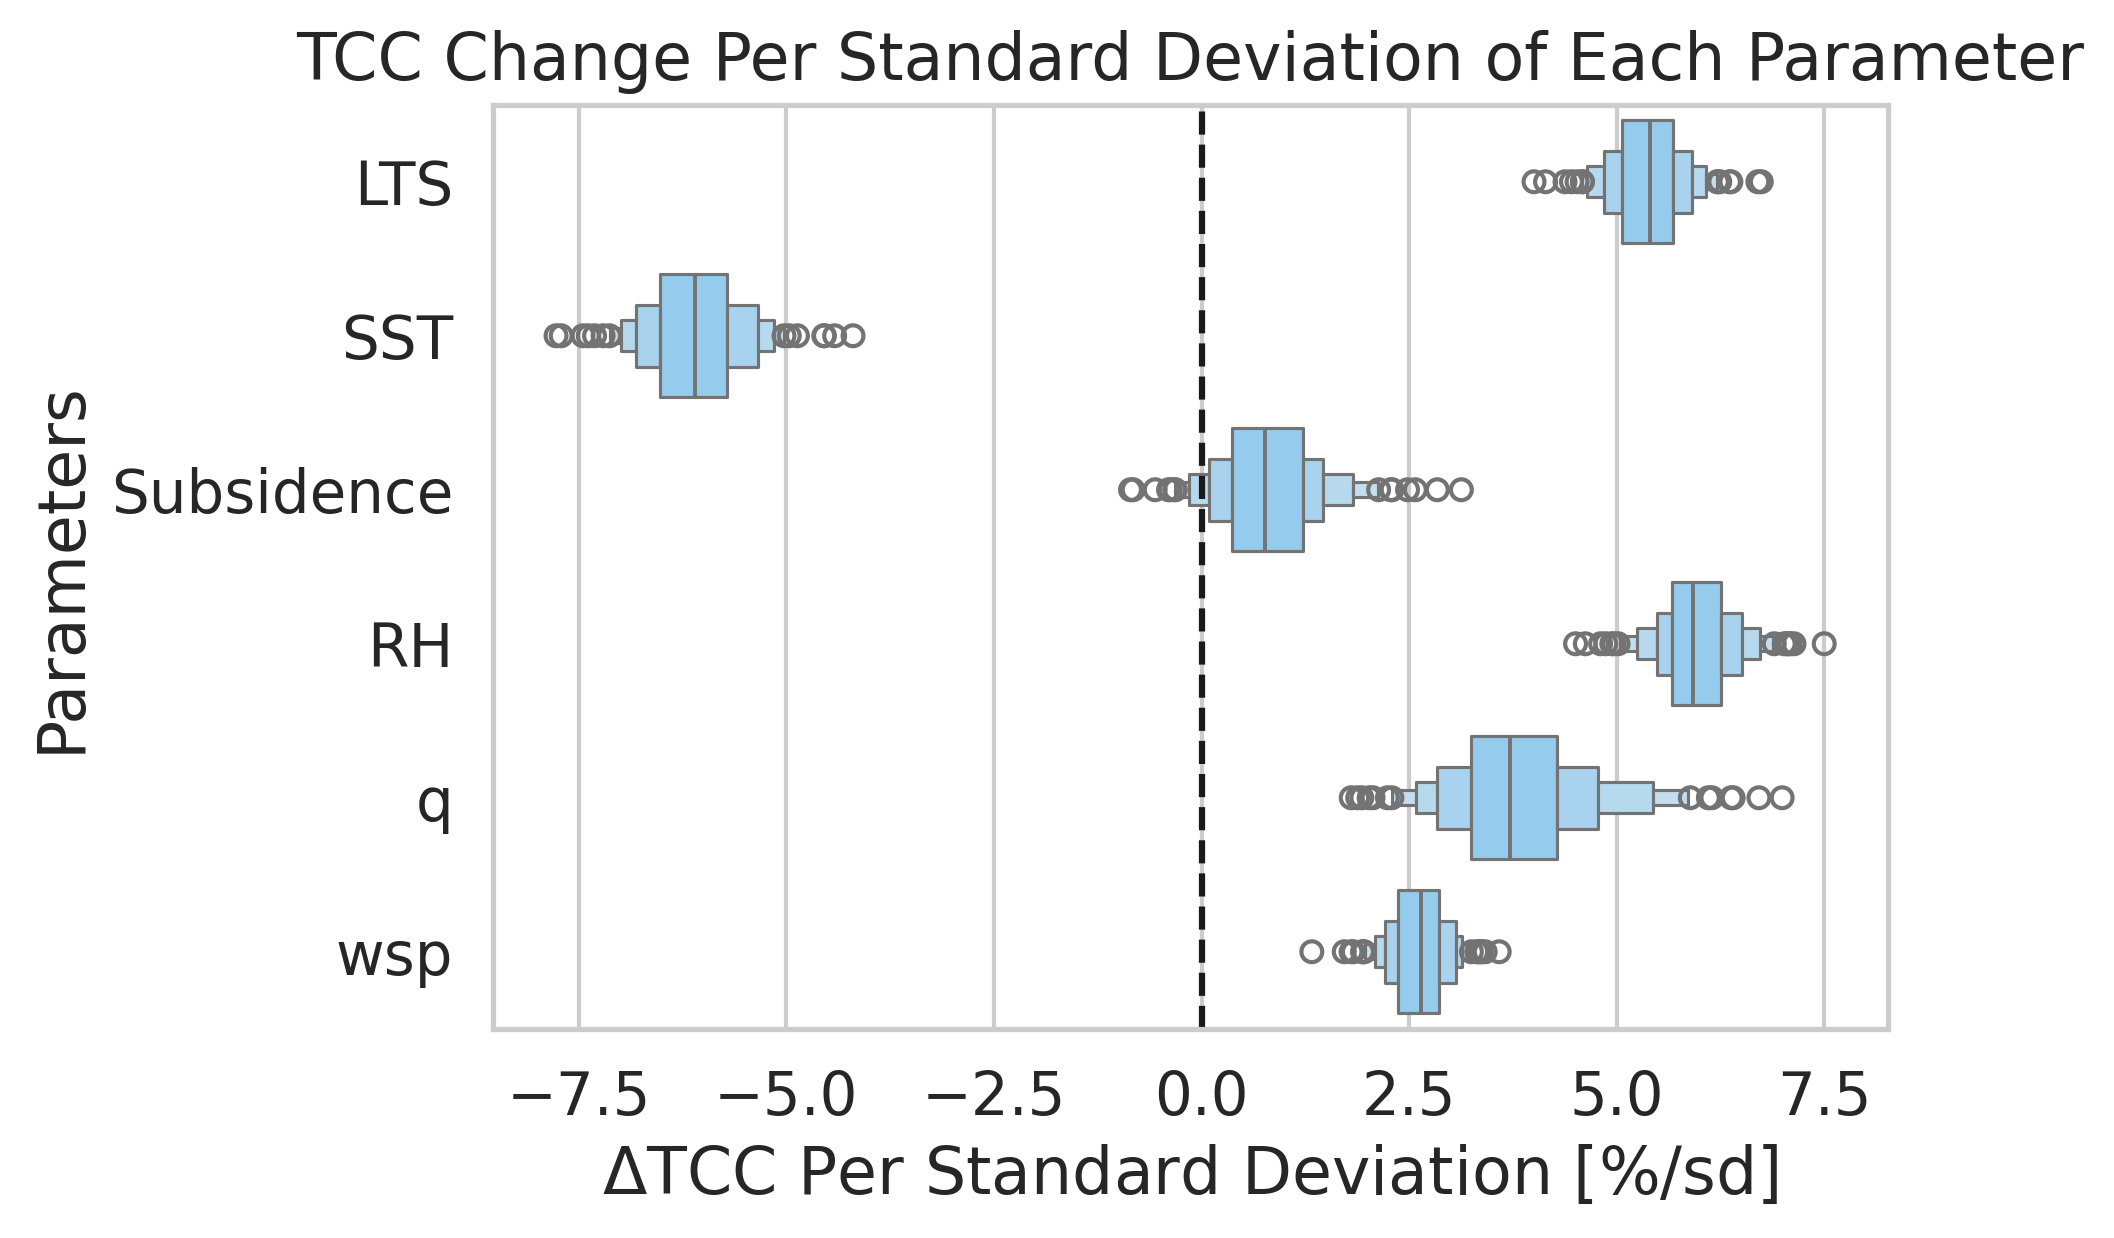

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.boxenplot(
    data=df_parameter_slope_by_sample,
    x="per_sd_slope",
    y="parameter_name",
    color="lightskyblue",
)
ax.axvline(x=0, color="k", linestyle="--")
ax.set(
    ylabel="Parameters",
    xlabel="$\Delta$TCC Per Standard Deviation [%/sd]",
    title="TCC Change Per Standard Deviation of Each Parameter"
)
plt.show()

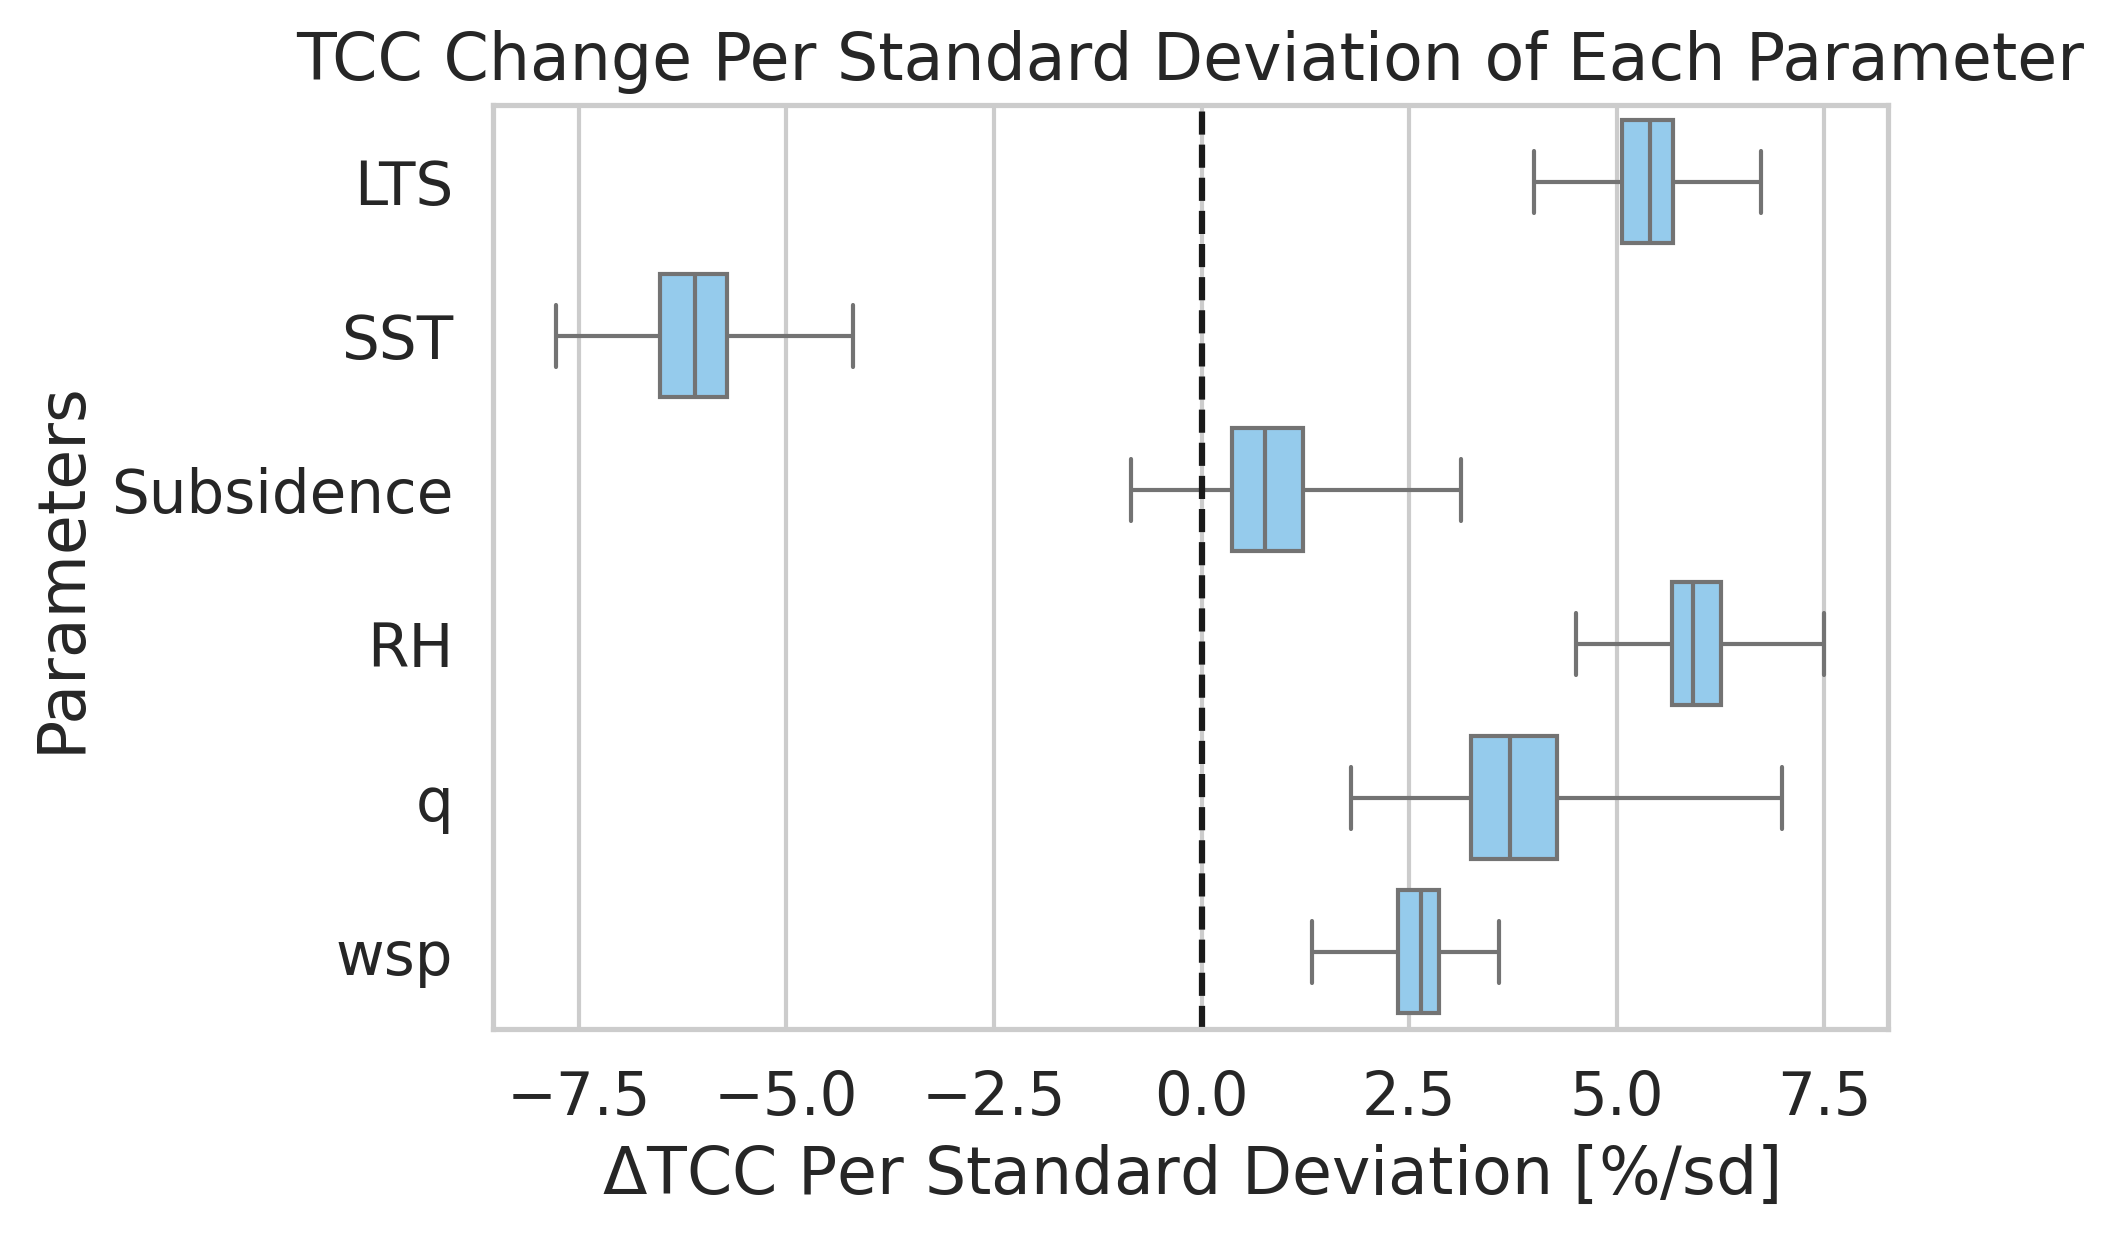

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.boxplot(
    data=df_parameter_slope_by_sample,
    x="per_sd_slope",
    y="parameter_name",
    color="lightskyblue",
    whis=10                 # get rid of the outliers
)
ax.axvline(x=0, color="k", linestyle="--")
ax.set(
    ylabel="Parameters",
    xlabel="$\Delta$TCC Per Standard Deviation [%/sd]",
    title="TCC Change Per Standard Deviation of Each Parameter"
)
plt.show()

In [34]:
df_parameter_slope_by_sample_ALTERED = df_parameter_slope_by_sample.copy()

df_parameter_slope_by_sample_ALTERED.loc[df_parameter_slope_by_sample_ALTERED["parameter_name"]=="SST", "per_sd_slope"] = -df_parameter_slope_by_sample_ALTERED.loc[df_parameter_slope_by_sample_ALTERED["parameter_name"]=="SST", "per_sd_slope"]
df_parameter_slope_by_sample_ALTERED.loc[df_parameter_slope_by_sample_ALTERED["parameter_name"]=="SST", "parameter_name"] = "$-$SST"

# df_parameter_slope_by_sample_ALTERED.loc[df_parameter_slope_by_sample_ALTERED["parameter_name"]=="Subsidence", "per_sd_slope"] = -df_parameter_slope_by_sample_ALTERED.loc[df_parameter_slope_by_sample_ALTERED["parameter_name"]=="Subsidence", "per_sd_slope"]
# df_parameter_slope_by_sample_ALTERED.loc[df_parameter_slope_by_sample_ALTERED["parameter_name"]=="Subsidence", "parameter_name"] = "$-$Subsidence"

df_parameter_slope_by_sample_ALTERED

parameter_name  parameter_sd        slope  per_sd_slope
0               LTS      3.682160     1.474747      5.430255
1            $-$SST      3.432865    -1.870305      6.420504
2        Subsidence      0.088050    -6.350635     -0.559175
3                RH      8.504339     0.684686      5.822803
4                 q      0.001954  1695.751908      3.314345
...             ...           ...          ...           ...
1195         $-$SST      3.379378    -1.843133      6.228642
1196     Subsidence      0.090022    15.889823      1.430434
1197             RH      8.457004     0.709834      6.003067
1198              q      0.001946  1669.681499      3.249568
1199            wsp      2.421778     1.026419      2.485758

[1200 rows x 4 columns]

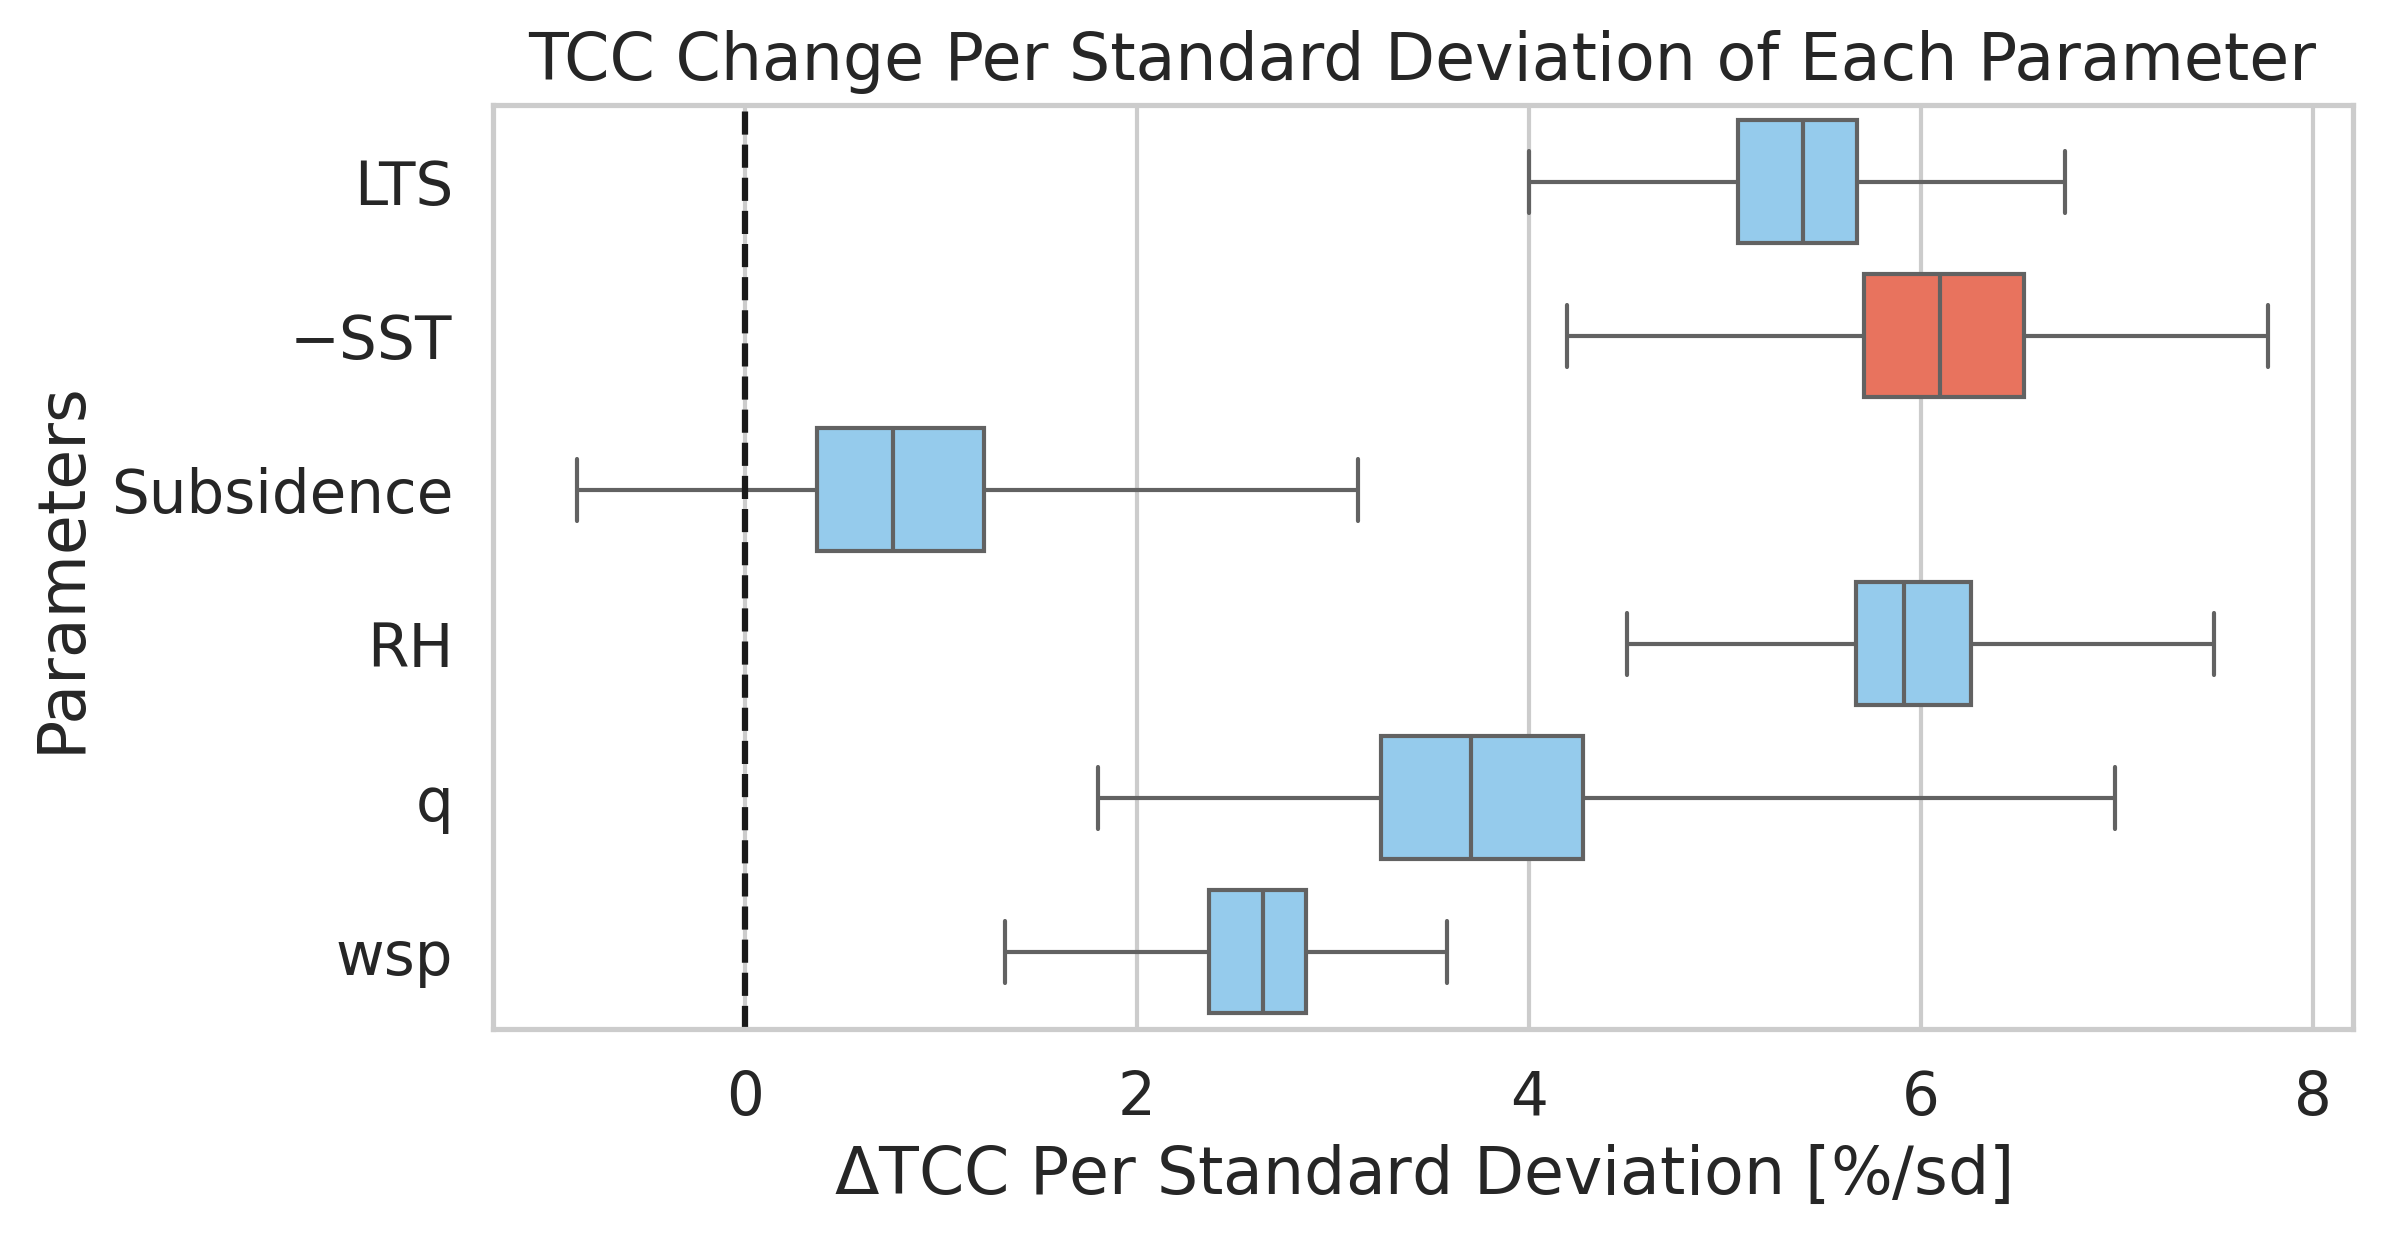

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(
    data=df_parameter_slope_by_sample_ALTERED,
    x="per_sd_slope",
    y="parameter_name",
    hue="parameter_name",
    whis=10,                 # get rid of the outliers
    palette=["lightskyblue", "tomato", "lightskyblue", "lightskyblue", "lightskyblue", "lightskyblue",],
    legend=False,
)
ax.axvline(x=0, color="k", linestyle="--")
ax.set(
    ylabel="Parameters",
    xlabel="$\Delta$TCC Per Standard Deviation [%/sd]",
    title="TCC Change Per Standard Deviation of Each Parameter"
)
plt.show()

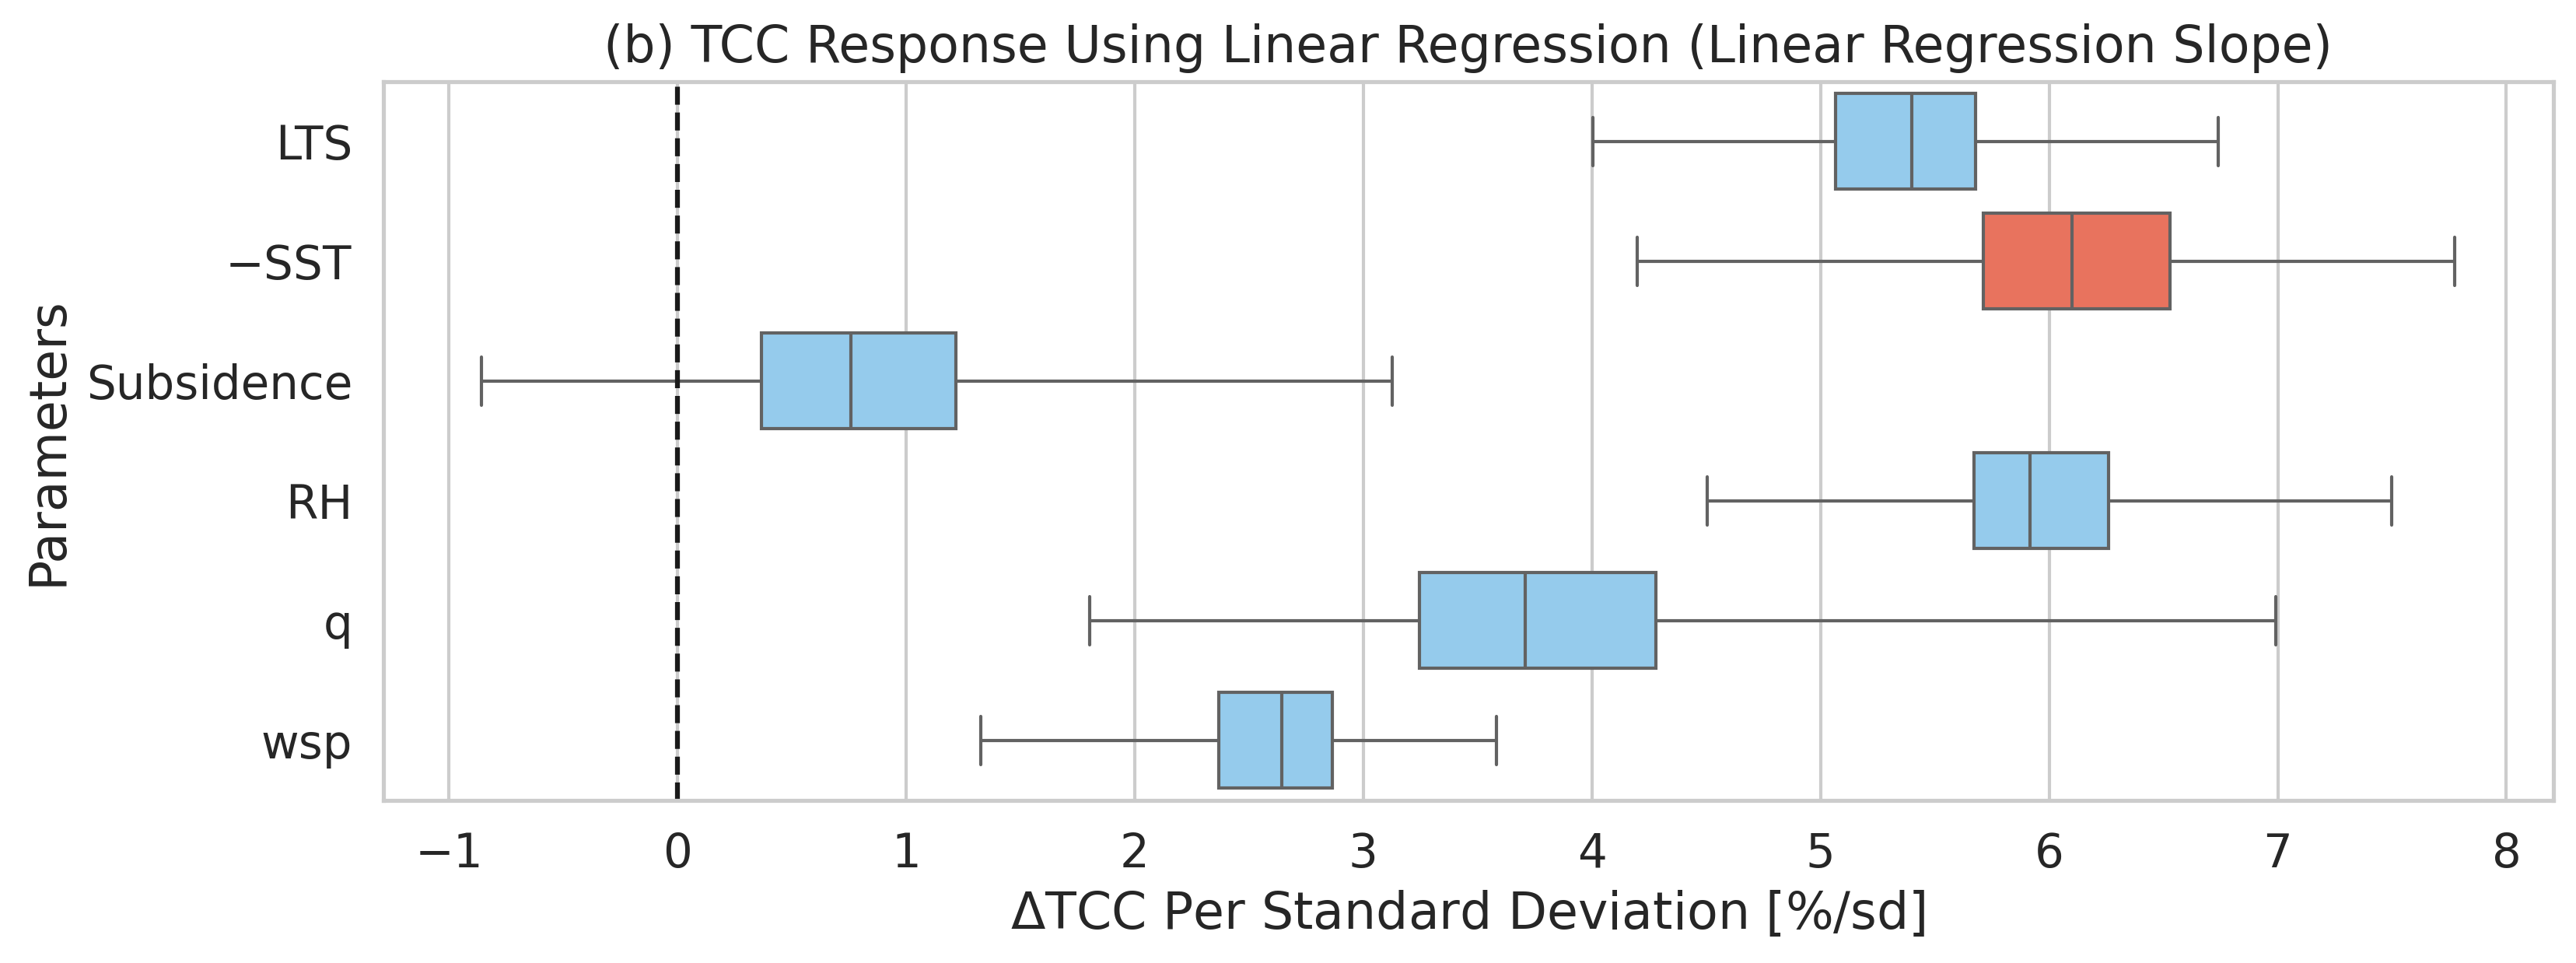

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.boxplot(
    data=df_parameter_slope_by_sample_ALTERED, 
    x="per_sd_slope",
    y="parameter_name",
    hue="parameter_name",
    whis=10,                 # get rid of the outliers
    palette=["lightskyblue", "tomato", "lightskyblue", "lightskyblue", "lightskyblue", "lightskyblue",],
    legend=False,
)
ax.axvline(x=0, color="k", linestyle="--")
ax.set(
    ylabel="Parameters",
    xlabel="$\Delta$TCC Per Standard Deviation [%/sd]",
    title="(b) TCC Response Using Linear Regression (Linear Regression Slope)",
    xticks=(-1, 0, 1, 2, 3, 4, 5, 6, 7, 8)
)
plt.show()

In [37]:
def soft_clamp(x, alpha):
    return utl.softclamp(x, 0, 100, alpha, alpha)

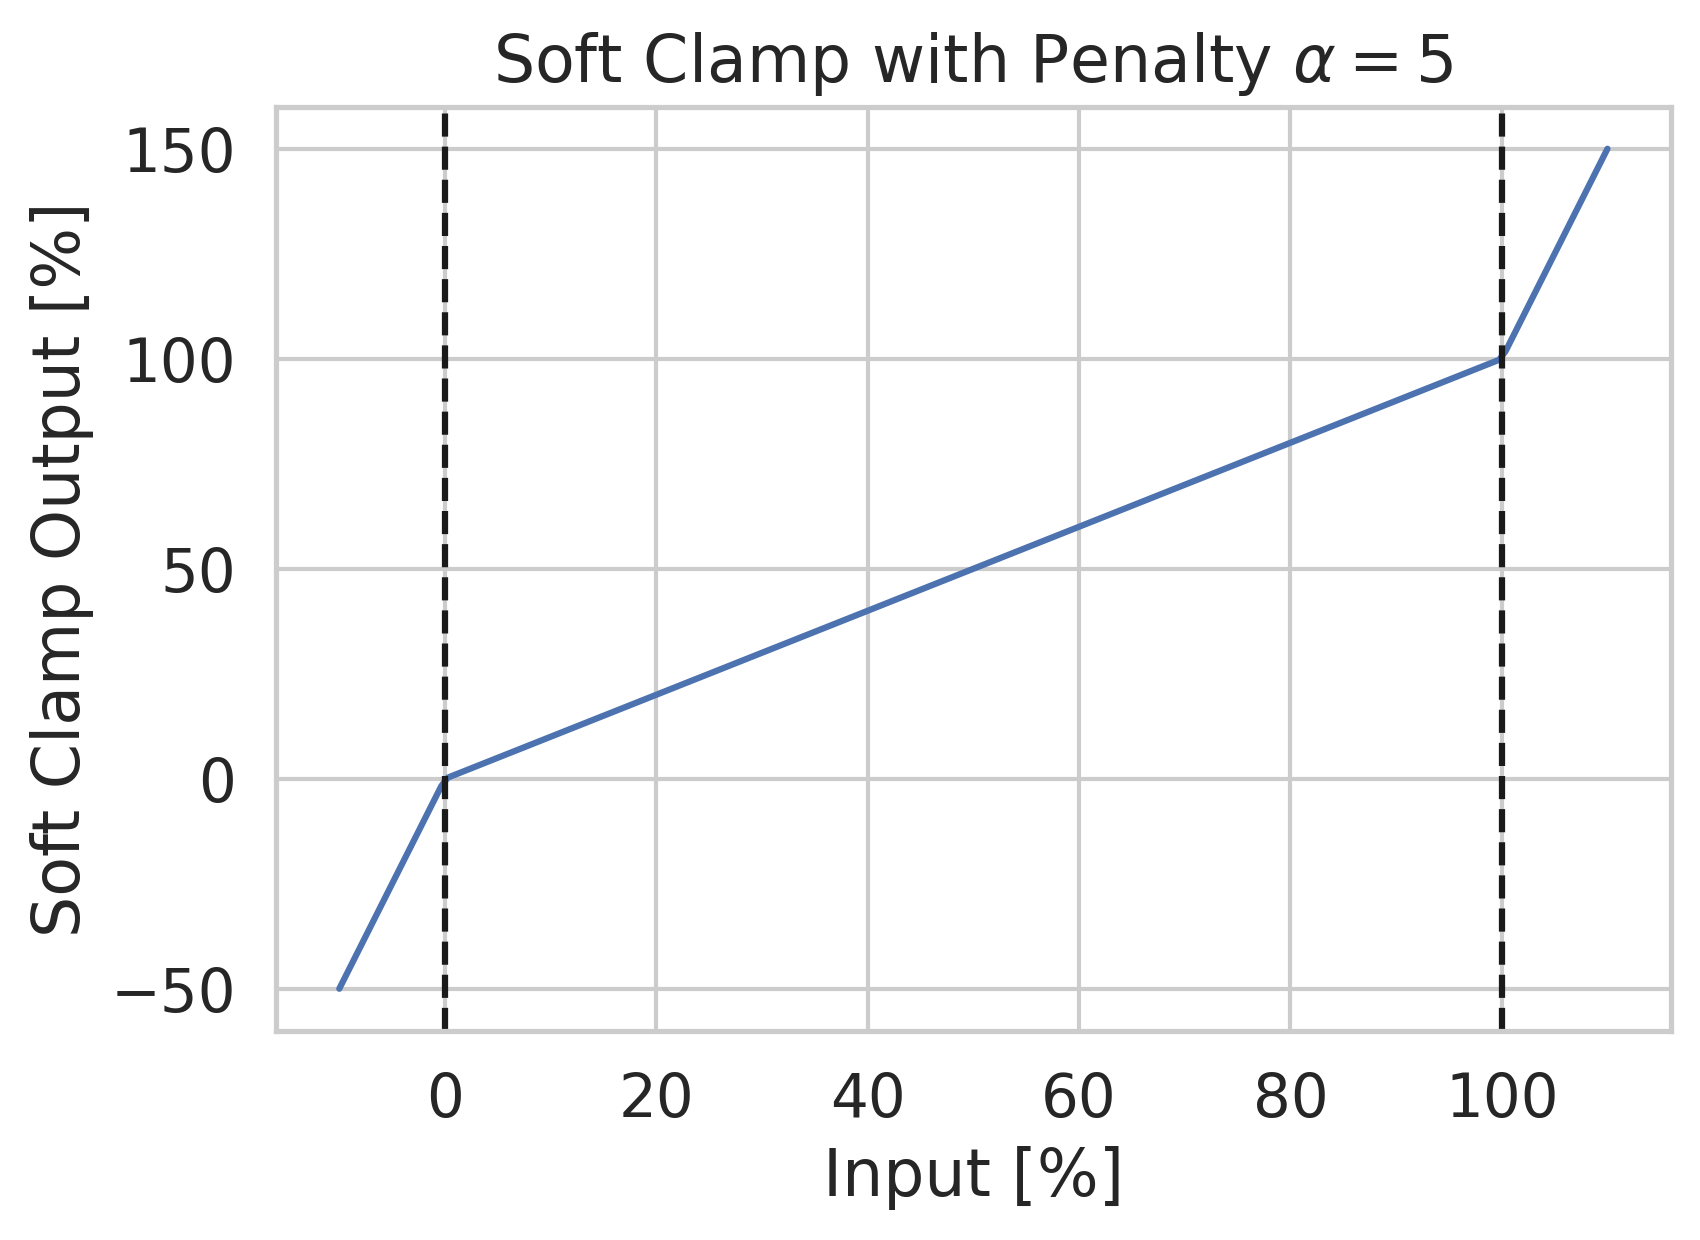

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(
    data=pd.DataFrame({
        "in": np.linspace(-10, 110, 200), 
        "out": soft_clamp(np.linspace(-10, 110, 200), 5)
    }),
    x="in",
    y="out",
)
ax.axvline(x=0, color="k", linestyle="--")
ax.axvline(x=100, color="k", linestyle="--")
ax.set(
    ylabel="Soft Clamp Output [%]",
    xlabel="Input [%]",
    title="Soft Clamp with Penalty $\\alpha =5$"
)
plt.show()